# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Нужно научиться определять рыночную стоимость объектов недвижимости. 

**Задача** — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание данных**

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import re
plt.style.use('dark_background') # темная тема графиков
pd.options.display.max_columns = 30 

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t', parse_dates=True)
    
except:
    pass

In [3]:
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9798,3,1550000.0,52.6,2017-10-23T00:00:00,2,NaN,5.0,29.7,3,NaN,False,False,8.3,0.0,деревня Торосово,NaN,NaN,NaN,NaN,NaN,NaN,30.0
18907,3,7300000.0,76.0,2016-06-17T00:00:00,3,NaN,22.0,43.0,2,NaN,False,False,14.0,1.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,731.0
11357,6,1900000.0,44.0,2018-09-11T00:00:00,2,2.5,5.0,NaN,1,NaN,False,False,6.0,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,63.0
20251,12,5800000.0,73.0,2018-09-11T00:00:00,3,NaN,5.0,46.0,2,NaN,False,False,8.0,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,79.0
9437,9,6000000.0,72.0,2017-02-21T00:00:00,4,NaN,5.0,NaN,2,False,False,False,NaN,0.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,44.0


In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
# Вывожу пропуски
data.isna().mean().sort_values(ascending=False).loc[lambda x: x > 0]

is_apartment           0.882906
parks_nearest          0.659100
ponds_nearest          0.615596
balcony                0.486054
ceiling_height         0.387991
airports_nearest       0.233850
cityCenters_nearest    0.232879
ponds_around3000       0.232837
parks_around3000       0.232837
days_exposition        0.134225
kitchen_area           0.096122
living_area            0.080299
floors_total           0.003629
locality_name          0.002068
dtype: float64

In [6]:
# проверим дубликаты в строках
data.duplicated().sum()

0

## Предобработка данных

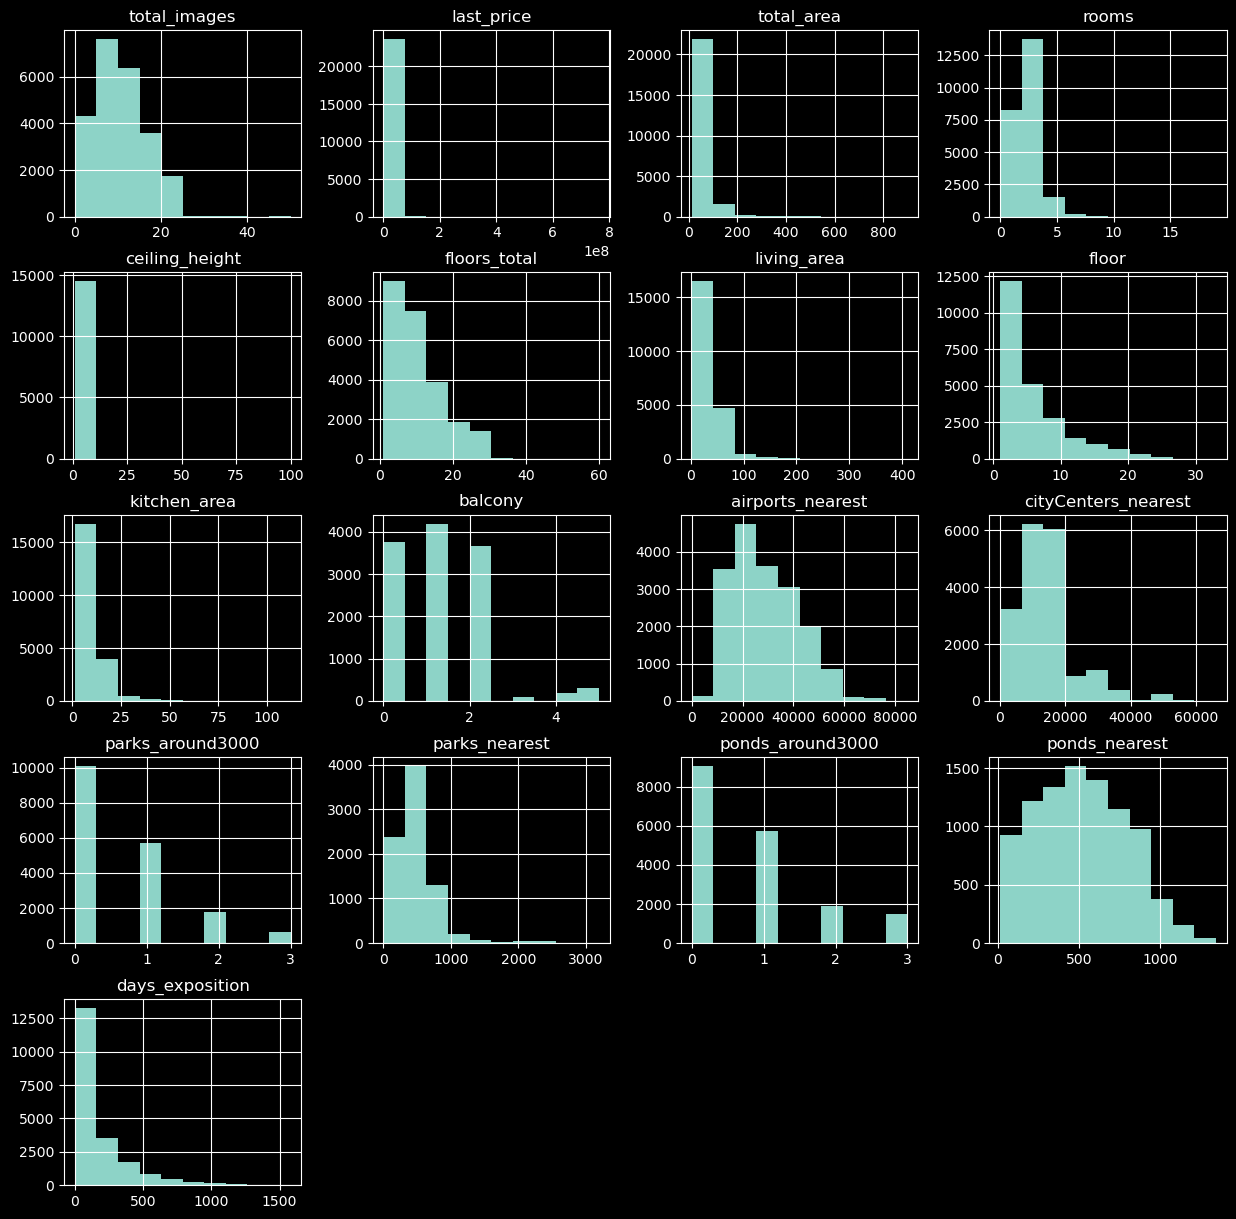

In [7]:
data.hist(figsize=(15, 15));

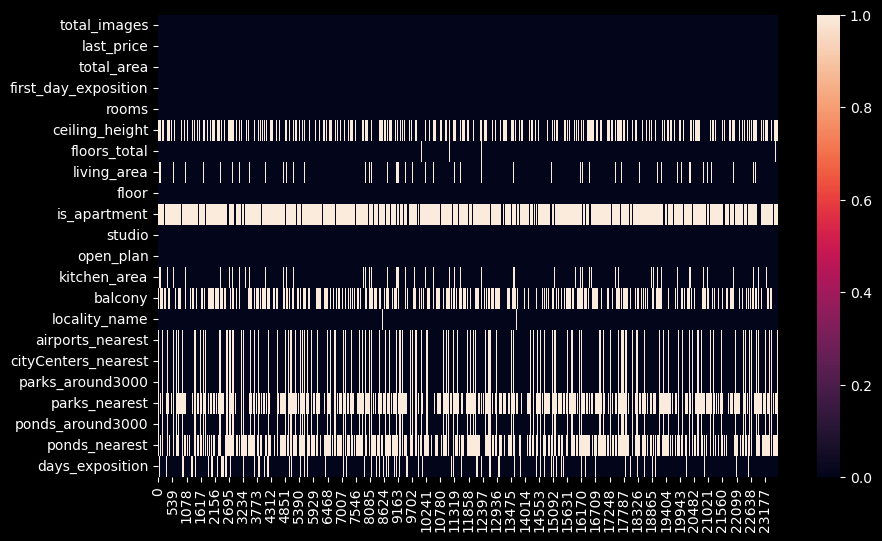

In [8]:
# Визуализируем пропуски


plt.figure(figsize=(10,6))
sns.heatmap(data.isna().transpose());

In [9]:
# Проверяем есть ли в данных некорректные наблюдения, где общая площадь квартиры меньше или равна жилой части
data.query('total_area <= living_area')

# вижу два интересных наблюдения, где площадь жилища и площадь жилой части совпадают, 
# при этом количество комнат 0, а площадь кухни не указана. Если бы это была студия, то колчиество комнат
# могли обозначить как 0 или 1, но здесь явно указано, что это не студия. Предположу, что это ошибочные данные,
# выбросы, поэтому удалю их.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9861,10,2350000.0,25.0,2017-12-03T00:00:00,0,NaN,22.0,25.0,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,13.0
12691,1,3700000.0,24.2,2017-11-10T00:00:00,0,NaN,19.0,24.2,13,NaN,False,True,NaN,1.0,Санкт-Петербург,17837.0,16840.0,0.0,NaN,2.0,210.0,74.0


In [10]:
data.drop(index=[9861, 12691]).query('total_area <= living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [11]:
# перезапишем данные без этих двух строк 

data = data.drop(index=[9861, 12691])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23697 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23697 non-null  int64  
 1   last_price            23697 non-null  float64
 2   total_area            23697 non-null  float64
 3   first_day_exposition  23697 non-null  object 
 4   rooms                 23697 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23611 non-null  float64
 7   living_area           21794 non-null  float64
 8   floor                 23697 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23697 non-null  bool   
 11  open_plan             23697 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12178 non-null  float64
 14  locality_name         23648 non-null  object 
 15  airports_nearest   

In [13]:
data['floor']

0         8
1         1
2         4
3         9
4        13
         ..
23694     3
23695     4
23696     1
23697    12
23698     1
Name: floor, Length: 23697, dtype: int64

In [14]:
data['floors_total']

0        16.0
1        11.0
2         5.0
3        14.0
4        14.0
         ... 
23694     5.0
23695     5.0
23696     3.0
23697    17.0
23698     5.0
Name: floors_total, Length: 23697, dtype: float64

In [15]:
# Проверяем есть ли в данных некорректные наблюдения, где общая площадь квартиры меньше или равна площади кухни
# Здесь все нормально
data.query('total_area <= kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [16]:
# здесь все нормально, в типе жилища студия не больше 1 комнаты
data.query('studio == True and rooms in rooms.unique()')['rooms'].unique()

array([0, 1], dtype=int64)

In [17]:
# Проверим, есть ли наблюдения, где общая площадь объекта МЕНЬШЕ, чем сумма жилой части и кухни

data.query('total_area * 0.9 <= (living_area + kitchen_area)')

# Такие наблюдения есть, предположу, что это выбросы, удалю их

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,NaN,14.0,59.0,8,False,False,False,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,NaN,False,False,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,NaN,False,False,6.2,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,NaN,False,False,9.0,NaN,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,NaN,False,False,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,NaN,5.0,90.2,4,NaN,False,False,16.0,NaN,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,NaN,5.0,42.2,2,NaN,False,False,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,NaN,14.0,40.0,8,NaN,False,False,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,NaN,4.0,44.0,2,NaN,False,False,15.3,NaN,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


<font color='blue'></font> 
<div class="alert alert-info">
<font size="4", color = "black"><b> </b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Введем ограничение total_area*0.9 <= (living_area + kitchen_area), нашлось 475 аномальных строк. Их я решил удалить
                                                               

In [18]:
# удаляем эти аномалии
data = data.drop(index=data.query('total_area * 0.9 <= living_area + kitchen_area').index)


In [19]:
# Проверяем удаление
data.query('total_area * 0.9  < living_area + kitchen_area')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


**Начнем дальше обрабатывать данные, то, что я описал выше будет подтверждением корректности в случае правильного
восстановления данных**

## Обработка аномалий

### Переведем типы данных

In [20]:
# распарсим дату из строки, время нигде не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [21]:
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23222, dtype: datetime64[ns]

In [22]:
# is_apartment переведем из object в bool

In [23]:
# данный столбец я не смогу восстановить из-за слишком большого числа пропусков
data['is_apartment'].isna().mean()

0.8832141934372578

In [24]:
data['is_apartment']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
23694    NaN
23695    NaN
23696    NaN
23697    NaN
23698    NaN
Name: is_apartment, Length: 23222, dtype: object

In [25]:
data['is_apartment'] = pd.to_numeric(data['is_apartment'], errors='coerce')

In [26]:
data['is_apartment'].unique()

array([nan,  0.,  1.])

In [27]:
# тип данных поменялся

**Остальные переменные буду менять в процессе заполнения пропусков и обучения моделей.**

### balcony

In [28]:
data['balcony'].isna().mean()

# 47% данных пропущено

0.4845835845319094

In [29]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [30]:
# предположим, что пропуски = владелец не указал балкон, возможно потому что его нет, заменим прпоуски на 0

data['balcony'] = data['balcony'].fillna(0)

In [31]:
data['balcony'].isna().mean()

0.0

### Площадь квартиры total_area

In [32]:
# значений много, построим гистограмму

<Axes: >

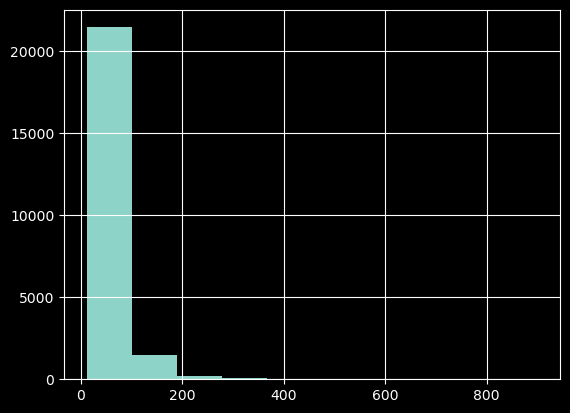

In [33]:
data['total_area'].hist()
# видим жирный хвост

In [34]:
# посмотрим сколько наблюдений с площадью квартиры более 300 квадратных метров и открытой планировкой

data.query('open_plan == True and total_area > 300')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19392,5,71000000.0,371.0,2018-07-26,0,3.57,7.0,NaN,6,NaN,False,True,NaN,0.0,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0


In [35]:
# меня смущает наблюдения с площадью квартиры 494.10 квадратных метра и всего 1 комнатой,
# причем, это не студия 
# предположу, что это выброс, проверим является ли это квартира с открытой планировкой
# нет, не является

In [36]:
data.query('total_area == 494.10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9826,1,43185328.0,494.1,2017-05-12,1,2.85,12.0,NaN,3,NaN,False,False,NaN,0.0,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0


In [37]:
data.query('total_area == 494.10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9826,1,43185328.0,494.1,2017-05-12,1,2.85,12.0,NaN,3,NaN,False,False,NaN,0.0,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0


In [38]:
data = data.drop(index=data.query('total_area == 494.10').index)


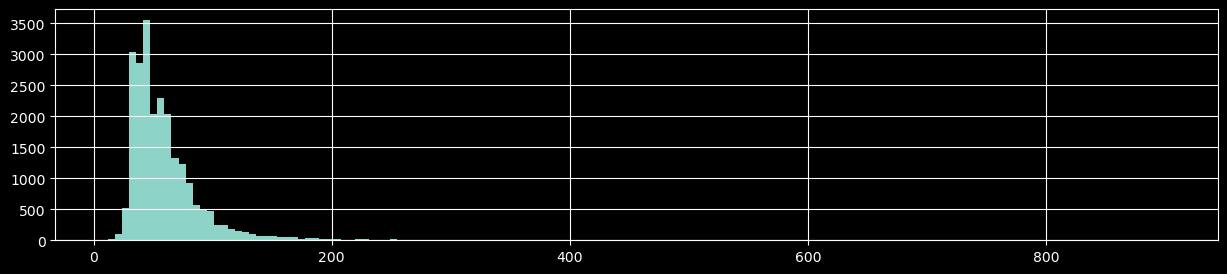

In [39]:
# Рассмотрим распрделение total_area подробнее

data.total_area.hist(bins = 150, figsize = (15,3));

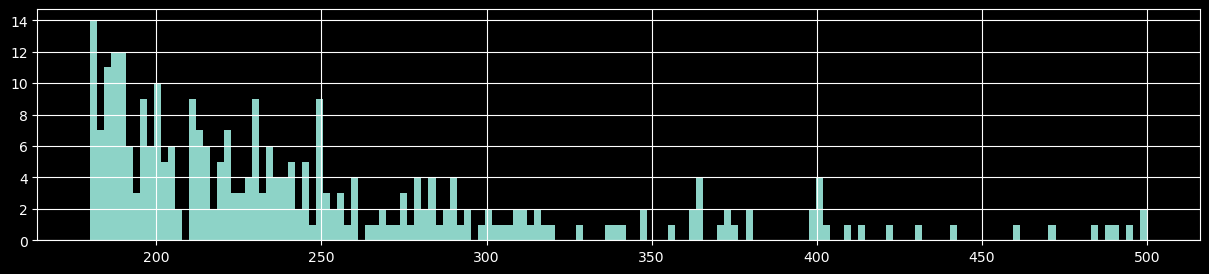

In [40]:
# рассмотрим график ближе

data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

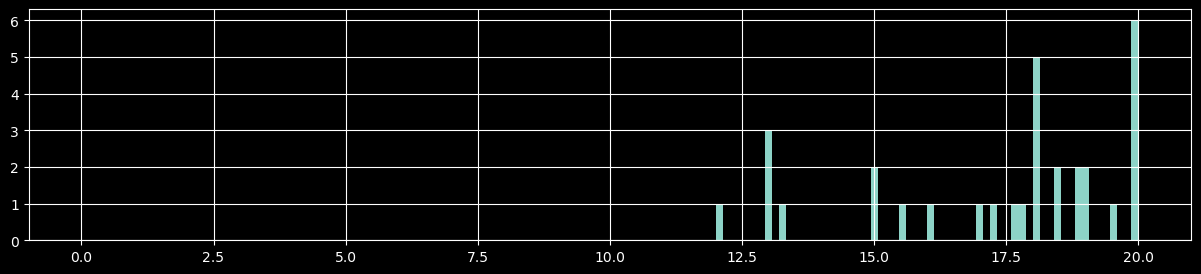

In [41]:
# также рассмотрим квартиры менее 20 кв.м таких наблюдений мало, также удалим их
data.total_area.hist(bins = 150, figsize = (15,3), range = (0,20));

In [42]:
# удалим наблюдения, где площадь квартиры более 250 кв.м и меньше 20 кв.м
# такие значения сильно выбиваются

data = data.query('total_area > 20 and total_area <= 250')

<font color='blue'></font> 
<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил значения, которые меньше 20 и больше 250 кв.м, такие наблюдения нетипичны и их очень мало

### Цена last_price

<Axes: >

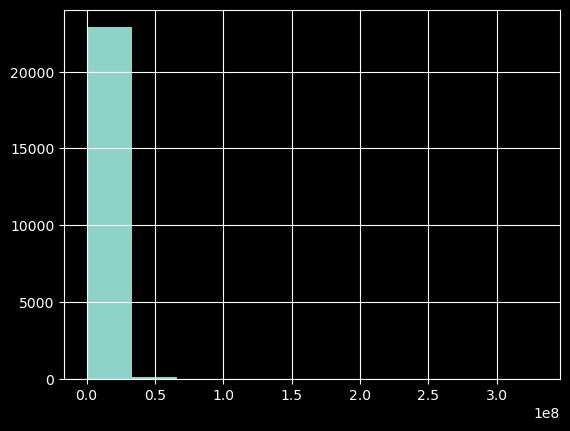

In [43]:
data['last_price'].hist()
# видим очень жирный хвост

<Axes: >

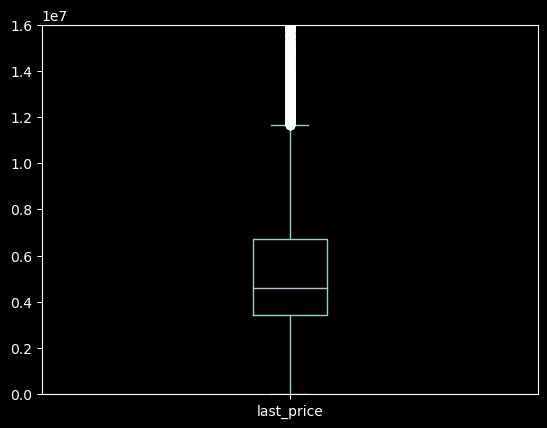

In [44]:
# видим, что boxplot говорит о том, что верхняя граница нормальности данных около 120 млн
data['last_price'].plot(kind='box', ylim=(0, 16000000))

In [45]:
data['last_price'].quantile(0.0005)

490000.0

In [46]:
# сильно выбивается значение 12190, это выброс
data.query('last_price < 490000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31,2,NaN,1.0,23.0,1,NaN,False,False,5.8,0.0,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,False,False,40.5,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31,2,NaN,5.0,30.3,3,NaN,False,False,5.5,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,NaN,3,NaN,False,False,NaN,0.0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000.0,32.0,2019-01-06,1,NaN,2.0,16.0,1,NaN,False,False,NaN,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000.0,38.5,2018-07-11,2,2.65,2.0,NaN,1,NaN,False,False,NaN,0.0,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000.0,40.0,2018-07-10,1,NaN,5.0,NaN,1,NaN,False,False,NaN,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,NaN,False,False,6.0,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17676,0,450000.0,36.5,2018-02-01,1,NaN,5.0,17.3,4,NaN,False,False,8.5,1.0,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.0
21912,0,470000.0,37.0,2018-02-18,1,NaN,3.0,NaN,3,NaN,False,False,NaN,0.0,поселок Совхозный,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [47]:
# найдем максимальную цену 
data['last_price'].max()

330000000.0

In [48]:
# рассмотрю наблюдения, где стоимость квартиры больше 130млн
data.query('last_price >= 130000000')

# таких наблюдений 8
# они нетипичны, их также удалю

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7.0,95.0,5,NaN,False,False,40.0,0.0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9.0,131.0,7,NaN,False,False,20.0,0.0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,501.0
7857,11,150000000.0,230.0,2017-10-25,8,NaN,8.0,220.0,8,NaN,False,False,NaN,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,135.0
12674,16,140000000.0,241.0,2015-07-24,5,3.00,5.0,NaN,4,NaN,False,False,NaN,0.0,Санкт-Петербург,23512.0,3503.0,3.0,413.0,3.0,83.0,399.0
13864,20,130000000.0,231.0,2015-08-13,6,3.60,6.0,148.0,4,NaN,False,False,12.0,0.0,Санкт-Петербург,22992.0,1280.0,3.0,395.0,3.0,170.0,467.0
17912,17,135000000.0,166.0,2019-02-07,3,3.30,7.0,52.0,1,NaN,False,False,64.0,0.0,Санкт-Петербург,32863.0,5955.0,2.0,230.0,3.0,215.0,NaN
19155,20,160000000.0,243.0,2018-11-12,5,NaN,5.0,145.0,4,NaN,False,False,33.0,0.0,Санкт-Петербург,22640.0,555.0,3.0,285.0,1.0,200.0,18.0
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6.0,63.7,6,NaN,False,False,30.2,0.0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN


In [49]:
# накладываю границы, чтобы избавиться от выбросов
data = data.query('last_price <= 130000000 and last_price > 490000')

<font color='blue'></font> 
<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил аномальные значения цен, которые посчитал выбросами, ориентируясь на boxplot и quantile, я оставил данные в промежутке [490000, 130000000]

### rooms

In [50]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8,  9, 10, 14], dtype=int64)

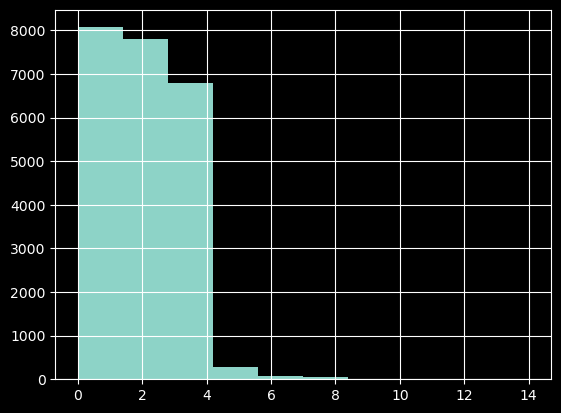

In [51]:
data['rooms'].hist();

In [52]:
data['rooms'].value_counts()

1     7885
2     7789
3     5662
4     1131
5      285
0      184
6       77
7       37
8        7
9        3
11       2
10       1
14       1
Name: rooms, dtype: int64

In [53]:
# и здесь я вижу, что больше 7 комнат очень мало значений, удалю их
data = data.query('rooms <= 7')

In [54]:
# посмотрю медину площадь по количеству комнат 

# поскольку наблюдений с количеством комнат более 7 мало, то рассмотрю только комнаты с количеством < 7
data.query('rooms < 7').groupby('rooms')['total_area'].median()

# предположу, что 0 комнат это, на самом деле 1 комната, поэтому данные нужно будет объединить

rooms
0     26.75
1     36.60
2     53.00
3     72.90
4     98.90
5    138.20
6    168.60
Name: total_area, dtype: float64

In [55]:
# заменяю 0 комнат на 1 комнату 
data.loc[(data['rooms']==0), 'rooms'] = 1

In [56]:
data['rooms'].value_counts()
# да, количество 1 комнат увеличилось на 197

1    8069
2    7789
3    5662
4    1131
5     285
6      77
7      37
Name: rooms, dtype: int64

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Комнат больше 7 очень мало, их я исключит из датафрейма

### total_images

<Axes: >

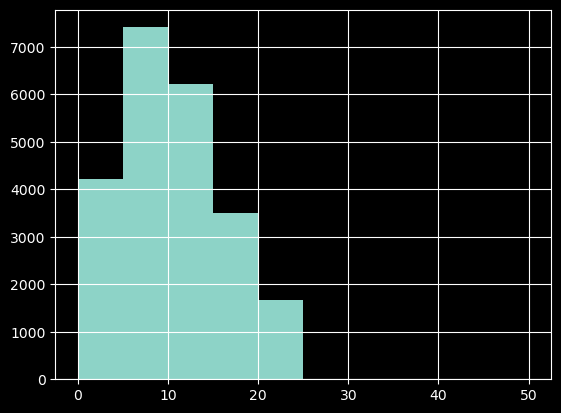

In [57]:
data['total_images'].hist()

In [58]:
data['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 28, 31, 22, 29, 26,
       50, 42, 37], dtype=int64)

In [59]:
# аномалий в данных я не вижу


In [60]:
# проверим пропуски

data['total_images'].isna().mean()

0.0

### floor

<Axes: >

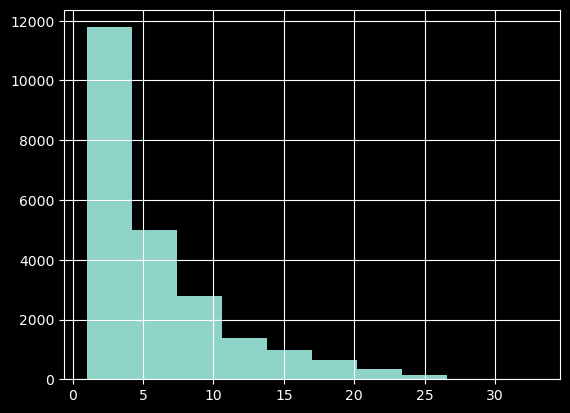

In [61]:
data['floor'].hist()

In [62]:
# не вижу здесь каких-либо аномалий
data['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31],
      dtype=int64)

In [63]:
data['floor'].value_counts()

2     3265
3     2975
1     2808
4     2732
5     2539
6     1274
7     1191
8     1062
9     1036
10     678
12     512
11     512
13     373
15     338
14     331
16     304
17     220
18     174
19     145
21     122
22     113
20     106
23      97
24      62
25      43
26      22
27      10
28       1
30       1
29       1
32       1
33       1
31       1
Name: floor, dtype: int64

In [64]:
# удалю эти единичные наблюдения

data = data.query('floor not in (28, 29, 30, 31, 32, 33)')

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил единичные наблюдения

### is_apartament

<Axes: >

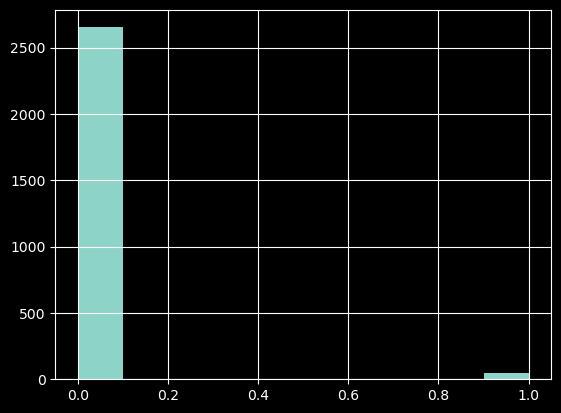

In [65]:
data['is_apartment'].hist()

In [66]:
data['is_apartment'].value_counts(dropna=False)


NaN    20345
0.0     2653
1.0       46
Name: is_apartment, dtype: int64

In [67]:
# пропусков много, но скорее всего, пропуски - это False, 
# то есть пользователь просто забыл указать

data['is_apartment'] = data['is_apartment'].fillna(False)

In [68]:
data['is_apartment'].fillna(False).value_counts(dropna=False)

False    22998
1.0         46
Name: is_apartment, dtype: int64

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Заполнил пропуски в апартаментах, скорее всего это False в пропусках и пользователь забыл это указать

### locality_name - избавление от неявных дубликатов

In [69]:
# видим 364 различных наименований 
data['locality_name'].nunique()

360

In [70]:
# приведем к нижнему регистру, чтобы избавиться от дубликатов с разным регистром
data['locality_name'] = data['locality_name'].str.lower()

In [71]:
# попробую через цикл с помощью регулярных выражений удалять подстроки в строке и привести населенные пукнты 
# к самому простому виду


def replace_name_duplicated(name):
    if name == 'NaN' or pd.isna(name) == True or name ==  float('nan'):
        return name
    
    else:
        new_str = name
        new_str = re.sub(r'\поселок городского типа\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\деревня\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\посёлок\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\городской\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\поселок\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\садовое товарищество\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\городского типа\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\село\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\при железнодорожной станции\b' , '', new_str, flags=re.IGNORECASE).strip()
        new_str = re.sub(r'\станции\b' , '', new_str, flags=re.IGNORECASE).strip()
        return new_str
    

In [72]:
data['locality_name'] = data['locality_name'].apply(replace_name_duplicated)

In [73]:
data['locality_name'].nunique()

302

In [74]:
# отлично! сократили число дубликатов!

In [75]:
# теперь посмотрим пропуски

In [76]:
data['locality_name'].isna().mean()


0.00212636695018226

In [77]:
data['locality_name'].value_counts()

санкт-петербург            15251
мурино                       576
кудрово                      466
шушары                       435
всеволожск                   385
                           ...  
белоостров                     1
пельгора                       1
каложицы                       1
платформа 69-й километр        1
дзержинского                   1
Name: locality_name, Length: 302, dtype: int64

In [78]:
# всего пропущено чуть более 2 процентов, могу заменить на моду или на новое значение "no_info"

# заменю на no_info

data['locality_name'] = data['locality_name'].fillna('no_info')

In [79]:
data['locality_name'].isna().mean()

0.0

### floors_total

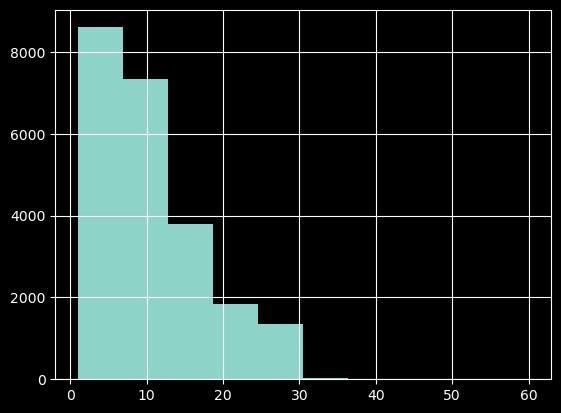

In [80]:
# переменная отвечает за количество этажей
data['floors_total'].hist();

In [81]:
data['floors_total'].isna().mean()

0.0036452004860267314

In [82]:
# найдем выбивающиеся одиночные значения
data.floors_total.value_counts(dropna=False).loc[lambda x: x==1]

34.0    1
60.0    1
29.0    1
36.0    1
52.0    1
37.0    1
Name: floors_total, dtype: int64

In [83]:
data.floors_total.value_counts(dropna=False)\
                .loc[lambda x: x==1].index

Float64Index([34.0, 60.0, 29.0, 36.0, 52.0, 37.0], dtype='float64')

In [84]:
data = data.query('floors_total not in ([34.0, 60.0, 29.0, 36.0, 52.0, 37.0])')

In [85]:
data.floors_total.describe()

count    22954.000000
mean        10.715605
std          6.561990
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64

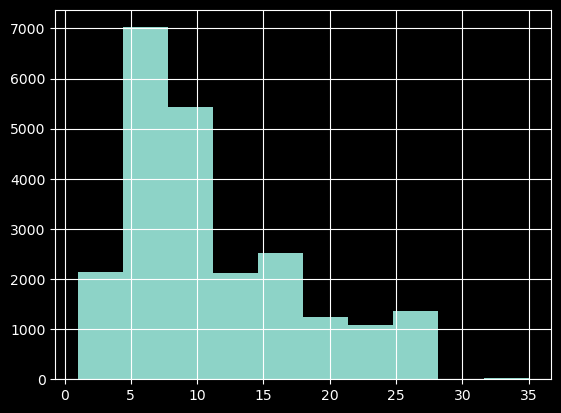

In [86]:
data.floors_total.hist();

In [87]:
# заполним пропуски

In [88]:
data['floors_total'] = data['floors_total'] \
                        .fillna(data.groupby(['locality_name'])['floors_total']
                        .transform('mean').astype('int'))


<Axes: >

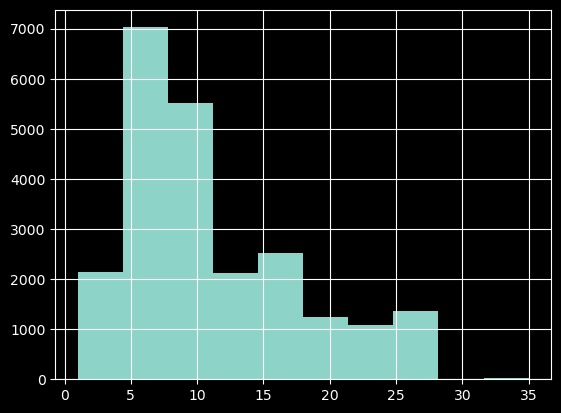

In [89]:
data['floors_total'].hist()

In [90]:
data['floors_total'].isna().mean()

0.0

### living_area

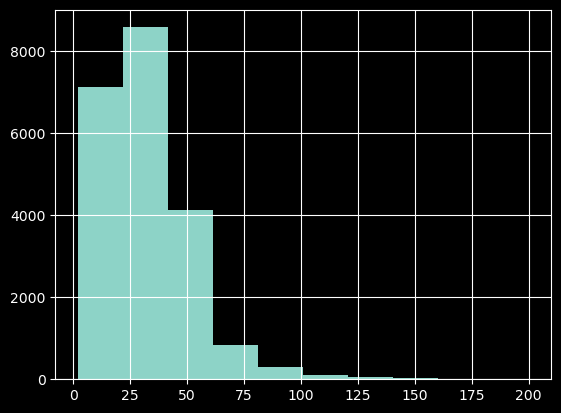

In [91]:
data['living_area'].hist();

<Axes: >

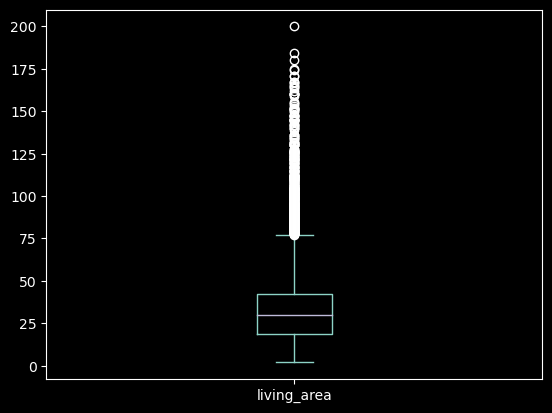

In [92]:
# boxplot говорит, что больше 80м это выбросы
data['living_area'].plot(kind='box')

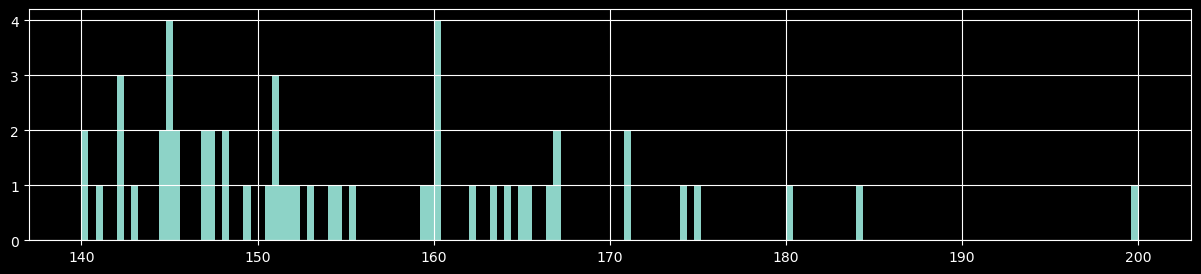

In [93]:
# рассмотрим гистограмму ближе, мне интересно посмотреть на аномальные
# значения после 140

data['living_area'].hist(bins=150, range=(140, 200), figsize=(15, 3));

In [94]:
data.query('living_area > 140')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
681,20,24900000.0,249.0,2015-08-13,7,NaN,5.0,180.0,4,False,False,False,NaN,1.0,санкт-петербург,24810.0,6108.0,0.0,NaN,0.0,NaN,781.0
1624,20,31500000.0,237.8,2017-04-09,5,3.57,5.0,144.6,4,False,False,False,26.0,1.0,санкт-петербург,39739.0,7011.0,2.0,447.0,2.0,486.0,NaN
1928,11,125000000.0,224.5,2017-01-24,4,NaN,4.0,163.5,3,0.0,False,False,30.0,1.0,санкт-петербург,22805.0,2335.0,0.0,NaN,2.0,497.0,174.0
2069,7,77000000.0,228.0,2017-04-09,4,NaN,4.0,165.0,1,False,False,False,26.0,0.0,санкт-петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN
3043,11,33000000.0,240.0,2018-08-20,6,NaN,8.0,184.0,4,False,False,False,21.0,1.0,санкт-петербург,12634.0,8164.0,1.0,292.0,3.0,449.0,NaN
3146,8,33000000.0,232.0,2019-01-23,5,3.86,6.0,144.5,3,False,False,False,15.0,0.0,санкт-петербург,25394.0,6310.0,1.0,306.0,0.0,NaN,47.0
3315,6,16250000.0,210.4,2019-04-08,7,2.57,16.0,159.2,15,False,False,False,15.4,0.0,санкт-петербург,21137.0,22849.0,0.0,NaN,2.0,348.0,NaN
4549,1,28000000.0,211.0,2016-03-17,5,4.00,5.0,153.0,2,0.0,False,False,15.0,0.0,санкт-петербург,21766.0,2067.0,1.0,692.0,1.0,51.0,266.0
4710,0,18000000.0,184.0,2016-02-26,5,NaN,7.0,142.0,5,False,False,False,15.0,0.0,санкт-петербург,22656.0,4288.0,1.0,556.0,0.0,NaN,175.0
4978,8,29000000.0,228.0,2016-12-29,4,3.50,3.0,141.0,2,False,False,False,40.4,1.0,пушкин,14651.0,26805.0,3.0,421.0,3.0,237.0,572.0


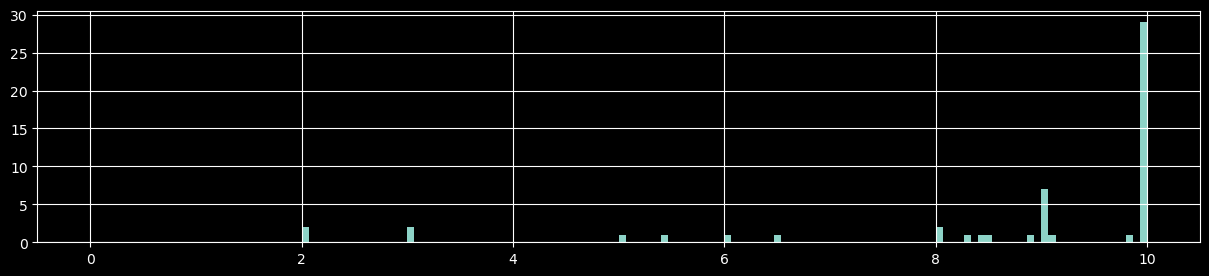

In [95]:
# теперь рассмотрю аномально маленькие значения

data['living_area'].hist(bins=150, range=(0, 10), figsize=(15, 3));

In [96]:

data.query('living_area < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000.0,21.40,2019-02-07,1,2.90,8.0,8.3,7,False,False,False,6.3,0.0,санкт-петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
680,14,7200000.0,43.00,2017-10-31,1,NaN,8.0,9.0,2,False,False,False,23.0,0.0,санкт-петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
1326,8,8100000.0,52.00,2017-01-29,2,2.70,25.0,9.0,15,False,False,False,32.0,2.0,санкт-петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
2309,10,4200000.0,62.40,2017-06-15,2,2.60,9.0,8.4,6,False,False,False,41.0,2.0,шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
3242,7,4440000.0,41.00,2017-07-02,1,NaN,17.0,3.0,17,False,False,False,11.0,0.0,санкт-петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
4100,17,5300000.0,34.80,2017-06-19,1,2.70,23.0,9.0,15,False,False,False,17.1,0.0,санкт-петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0
8325,9,4800000.0,52.00,2017-10-25,2,NaN,5.0,9.0,2,False,False,False,6.0,1.0,санкт-петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0
13915,20,6350000.0,52.00,2018-02-06,2,3.00,6.0,2.0,2,False,False,False,9.0,0.0,санкт-петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
15833,20,4600000.0,33.00,2017-01-01,1,2.70,22.0,9.0,12,False,False,False,14.3,1.0,санкт-петербург,33803.0,13671.0,0.0,NaN,0.0,NaN,511.0
16431,13,3799000.0,31.00,2018-04-12,1,2.60,5.0,6.0,1,False,False,False,17.0,0.0,санкт-петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0


In [97]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.00,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.6,1,False,False,False,11.00,2.0,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.3,4,False,False,False,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.00,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,False,False,13.83,0.0,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.0,4,False,False,False,8.50,0.0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,False,False,False,NaN,0.0,рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,False,False,23.30,2.0,санкт-петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [98]:
# удалю аномальные значения, которые меньше 10 и больше 140

data = data.drop(index=data.query('living_area < 10 or living_area >= 140').index)

In [99]:
# 8 процентов данных пропущено
data['living_area'].isna().mean()

0.081311789556204

In [100]:
# также посмотрим есть ли наблюдения, где жилая площадь меньше размера кухни в 2 раза, мне кажется это странные наблюдения

data.query('kitchen_area > living_area*2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2154,9,10800000.0,56.3,2018-07-02,1,2.80,5.0,11.4,2,False,False,False,27.4,0.0,санкт-петербург,36813.0,8572.0,1.0,2467.0,3.0,214.0,NaN
4074,17,12750000.0,56.6,2016-05-12,1,2.97,7.0,13.3,2,False,False,False,30.5,2.0,санкт-петербург,33052.0,6555.0,0.0,NaN,3.0,121.0,683.0
6944,6,14400000.0,100.7,2015-09-24,1,NaN,5.0,16.4,1,False,False,False,43.4,0.0,санкт-петербург,36779.0,14931.0,0.0,NaN,0.0,NaN,NaN
10439,9,5900000.0,43.0,2018-11-02,1,NaN,12.0,10.0,8,False,False,False,22.0,0.0,санкт-петербург,17720.0,16722.0,3.0,471.0,2.0,440.0,NaN
15740,9,4800000.0,50.0,2017-02-25,1,NaN,6.0,12.0,1,False,False,False,25.0,0.0,санкт-петербург,25233.0,4069.0,0.0,NaN,0.0,NaN,164.0
16034,15,12900000.0,60.2,2015-07-30,2,3.60,5.0,10.5,3,False,False,False,30.0,0.0,санкт-петербург,23431.0,4213.0,0.0,NaN,0.0,NaN,529.0
19468,4,2450000.0,43.6,2017-09-22,1,2.60,9.0,10.0,9,False,False,False,22.3,0.0,никольское,NaN,NaN,NaN,NaN,NaN,NaN,123.0
21331,15,16000000.0,93.4,2019-03-26,3,2.80,17.0,24.3,6,False,False,False,49.4,0.0,санкт-петербург,30954.0,8248.0,0.0,NaN,2.0,495.0,NaN
21399,16,5500000.0,42.0,2018-03-26,1,3.00,5.0,10.5,1,False,False,False,22.0,0.0,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,352.0


In [101]:
# удалю эти наблюдения
data = data.drop(index=data.query('kitchen_area > living_area*2').index)

In [102]:
# посмотрим от чего зависит living_area
phik = data.phik_matrix()

interval columns not set, guessing: ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']


C:\ProgramData\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable first_day_exposition is large: 1488. Are you sure this is not an interval variable? Analysis for pairs of variables including first_day_exposition can be slow.
  warnings.warn(


In [103]:
phik['living_area'].sort_values(ascending=False).loc[lambda x: x > 0.8]

# и видим 2 переменные, от которых сильнее всего зависит living_area

living_area    1.000000
total_area     0.912500
rooms          0.819461
Name: living_area, dtype: float64

In [104]:
data['living_area'].isna().mean()

0.08134367375392122

In [105]:
# давай подумаем от чего зависит жилая площадь, при это нужно соблюдать условие, 
# чтобы сумма жилой площади и площади кухни была меньше общей площади.

# Предположу, что зависит от total_area 

data.groupby(['total_area'])['living_area'].transform('median').isna().mean()


0.005446148483792262

In [106]:
# скопирую датасет, чтобы не сломать его и посмотрим как отработает условие
data_test = data.copy(deep=True)

In [107]:
data_test.apply(lambda x: x['total_area'] - x['kitchen_area'], axis=1).isna().mean()

0.09646218194492855

In [108]:
data_test['living_area'].isna().mean()

0.08134367375392122

In [109]:
data_test['living_area'] = data_test['living_area'].fillna(data.groupby(['total_area'])['living_area'].transform('median')
)

In [110]:
data_test['living_area'] = data_test['living_area'].fillna(data_test['living_area'].mean())

In [111]:
data_test['living_area'].isna().mean()

0.0

<Axes: >

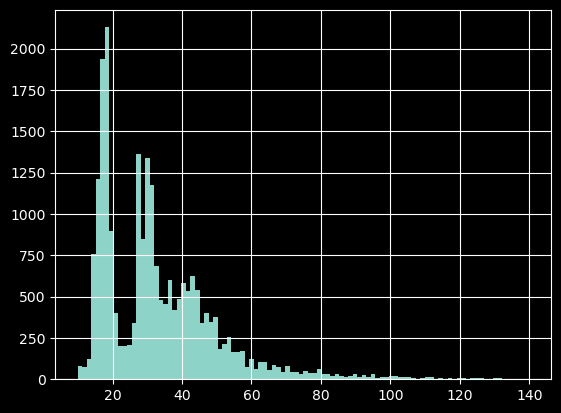

In [112]:
data_test['living_area'].hist(bins=100)

In [113]:
# теперь переношу изменения на основной датасет

data['living_area'] = data['living_area'].fillna(data.groupby(['total_area'])['living_area'].transform('median')
)

In [114]:
data['living_area'] = data['living_area'].fillna(data['living_area'].mean())

In [115]:
# проверим, что выполняется условие для заполненных 

In [116]:
# Проверим, есть ли наблюдения, где общая площадь объекта МЕНЬШЕ, чем сумма жилой части и кухни

data.query('total_area*0.9 <= living_area + kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1770,10,2566270.0,42.07,2018-12-13,1,NaN,15.0,33.197356,8,False,False,False,11.11,0.0,новогорелово,NaN,NaN,NaN,NaN,NaN,NaN,11.0
1832,4,3055000.0,32.84,2018-03-28,1,NaN,24.0,33.197356,2,False,False,False,11.05,0.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,80.0
1983,7,1950000.0,44.60,2019-03-19,1,2.50,5.0,28.000000,5,False,False,False,14.00,0.0,кириши,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2386,8,3085000.0,34.12,2018-07-29,1,2.80,8.0,33.197356,1,False,False,False,10.51,1.0,санкт-петербург,19983.0,18985.0,1.0,346.0,0.0,NaN,45.0
2519,6,3511000.0,39.41,2018-08-07,1,2.65,27.0,33.197356,12,False,False,False,11.28,1.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21016,4,3700000.0,40.00,2016-03-19,2,NaN,16.0,18.000000,13,False,False,False,18.00,0.0,санкт-петербург,8255.0,11911.0,2.0,40.0,1.0,345.0,96.0
21480,4,5318994.0,48.10,2018-06-09,1,NaN,3.0,29.200000,3,False,False,False,16.80,0.0,санкт-петербург,45767.0,21700.0,0.0,NaN,1.0,576.0,275.0
21993,8,4310000.0,31.48,2019-03-24,1,2.75,25.0,33.197356,5,False,False,False,10.00,2.0,санкт-петербург,35134.0,16298.0,0.0,NaN,1.0,674.0,28.0
22277,3,3725000.0,38.35,2018-07-30,1,2.70,18.0,33.197356,7,False,False,False,10.30,1.0,санкт-петербург,15360.0,13094.0,0.0,NaN,1.0,493.0,49.0


In [117]:
# удалим эти наблюдения

data = data.drop(index=data.query('total_area*0.9 <= living_area + kitchen_area').index)

In [118]:
# а также проверим есть ли наблюдения, где жилая часть больше общей площади

data.query('living_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1608,12,2150000.0,20.10,2019-01-30,1,NaN,9.0,33.197356,1,1.0,False,False,NaN,0.0,санкт-петербург,26646.0,12147.0,0.0,NaN,0.0,NaN,13.0
5187,5,3300000.0,25.40,2018-11-02,1,NaN,19.0,33.197356,15,False,True,False,NaN,0.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,3.0
10418,2,2930000.0,30.26,2018-09-12,1,2.7,16.0,33.197356,15,False,False,False,NaN,0.0,санкт-петербург,34227.0,15391.0,0.0,NaN,2.0,724.0,45.0
11292,1,2925000.0,25.15,2016-06-01,1,NaN,11.0,33.197356,7,False,False,False,NaN,0.0,санкт-петербург,8426.0,12082.0,2.0,24.0,1.0,271.0,78.0
11425,1,2100000.0,25.53,2016-05-10,1,NaN,19.0,33.197356,4,False,False,False,NaN,0.0,мурино,51553.0,21888.0,0.0,NaN,2.0,133.0,61.0
14153,1,1995000.0,23.17,2016-06-22,1,NaN,11.0,33.197356,4,False,False,False,NaN,0.0,санкт-петербург,8426.0,12082.0,2.0,24.0,1.0,271.0,34.0
16685,6,2150000.0,21.80,2018-09-05,1,NaN,18.0,33.197356,3,False,False,False,NaN,1.0,бугры,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21476,3,3045000.0,32.83,2018-02-22,1,NaN,22.0,33.197356,4,False,False,False,NaN,0.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0


In [119]:
# удалим эти наблюдения

data = data.drop(index=data.query('living_area > total_area').index)

In [120]:
data['living_area'].isna().mean()

0.0

<Axes: >

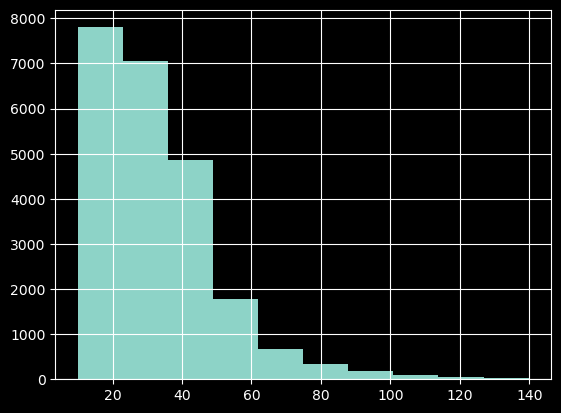

In [121]:
# посмотрим сильно ли изменилось распределение
data['living_area'].hist()


<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы в значениях площади, а также проверил условия, которые указывал в начале проекта и удалил те значения, которые не попали. Восстановил пропуски с помощью total_area, у living_area корреляция phik с ним больше 0.9 это сильная связь

### kitchen_area

<Axes: >

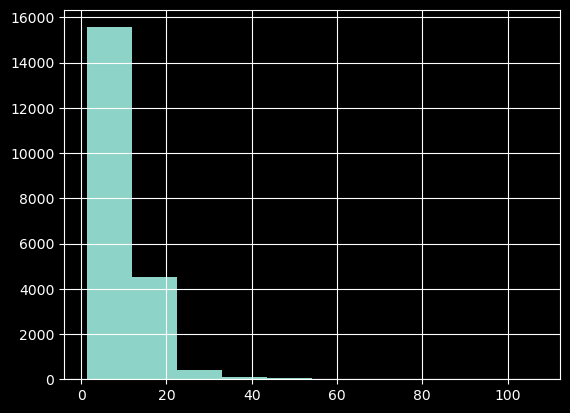

In [122]:
data['kitchen_area'].hist()

<Axes: >

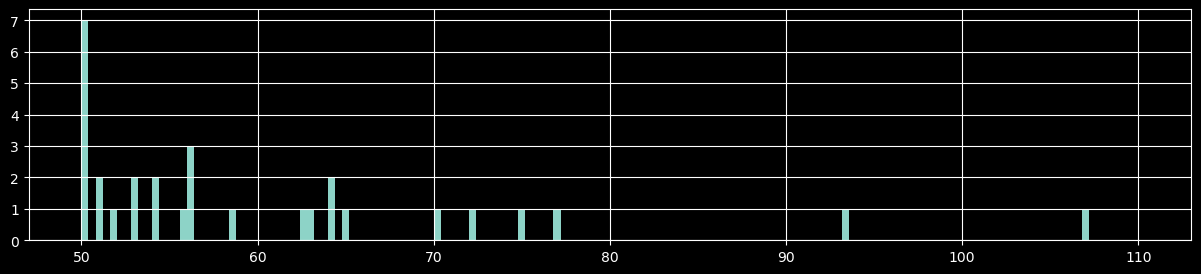

In [123]:
# рассмотрим ближе хвосты

# видим выбросы, учтем их при удалении выбросов
data['kitchen_area'].hist(bins=150, range=(50, 110), figsize=(15, 3))

<Axes: >

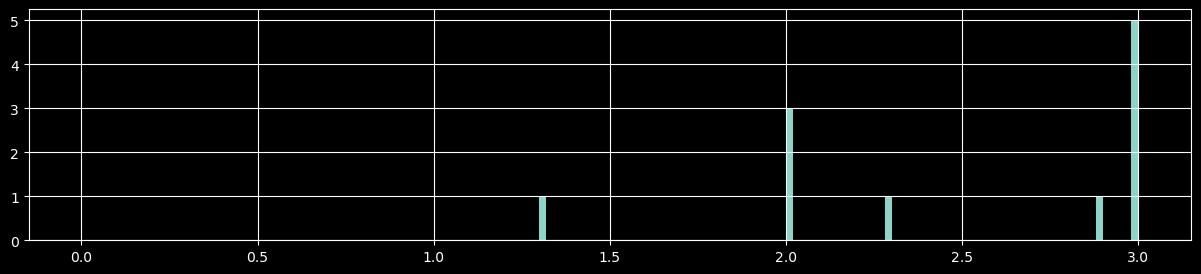

In [124]:
# рассмотрим ближе хвосты

# видим выбросы, учтем их при удалении выбросов
data['kitchen_area'].hist(bins=150, range=(0, 3), figsize=(15, 3))

In [125]:
# уберу из данных выбросы

data = data.drop(index=data.query('kitchen_area <=3 or kitchen_area >= 50').index)

In [126]:
data['kitchen_area'].isna().mean()

0.09658493870402803

In [127]:
phik['kitchen_area'].sort_values(ascending=False).loc[lambda x: x > 0.6]

# и видим 2 переменные, от которых сильнее всего зависит living_area

kitchen_area    1.000000
total_area      0.626113
last_price      0.600186
Name: kitchen_area, dtype: float64

In [128]:
data['kitchen_area'].isna().mean()

0.09658493870402803

In [129]:
# давай подумаем от чего зависит kitchen_area, при это нужно соблюдать условие, 
# чтобы сумма жилой площади и площади кухни была меньше общей площади.

# Предположу, что зависит от total_area 

data.groupby(['total_area'])['kitchen_area'].transform('median').isna().mean()


0.008012259194395797

In [130]:
# скопирую датасет, чтобы не сломать его и посмотрим как отработает условие
data_test = data.copy(deep=True)

In [131]:
data_test['kitchen_area'].isna().mean()

0.09658493870402803

In [132]:
data_test['kitchen_area'] = data_test['kitchen_area'].fillna(data.groupby(['total_area'])['kitchen_area'].transform('median')
)

In [133]:
data_test['kitchen_area'] = data_test['kitchen_area'].fillna(data_test['kitchen_area'].mean())

In [134]:
data_test['kitchen_area'].isna().mean()

0.0

<Axes: >

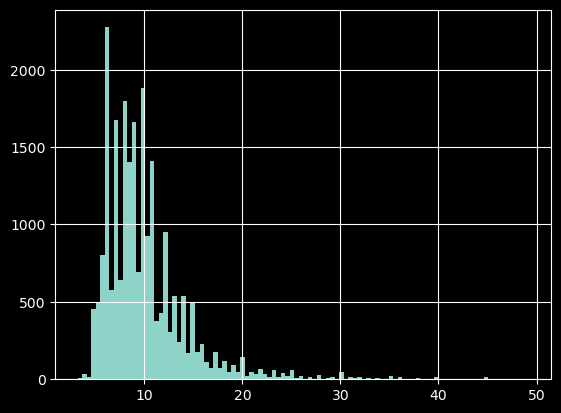

In [135]:
data_test['kitchen_area'].hist(bins=100)

In [136]:
# теперь переношу изменения на основной датасет

data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby(['total_area'])['kitchen_area'].transform('median')
)

In [137]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())

In [138]:
# проверим, что выполняется условие для заполненных 

In [139]:
# Проверим, есть ли наблюдения, где общая площадь объекта МЕНЬШЕ, чем сумма жилой части и кухни

data.query('total_area*0.9 <= living_area + kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
237,4,2438033.0,28.10,2016-11-23,1,NaN,11.0,20.75,1,False,False,False,6.800000,0.0,санкт-петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
424,14,11500000.0,98.00,2016-05-10,3,2.65,3.0,88.00,3,0.0,False,False,13.100000,1.0,санкт-петербург,39363.0,13270.0,0.0,NaN,0.0,NaN,90.0
440,8,2480000.0,27.11,2018-03-12,1,NaN,17.0,24.75,4,False,True,False,10.116461,2.0,санкт-петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28,1,NaN,26.0,24.30,19,False,False,True,8.700000,1.0,парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
697,12,2500000.0,24.10,2017-12-01,1,2.75,25.0,17.50,21,False,True,False,10.116461,0.0,кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23102,0,5800000.0,66.00,2017-06-09,5,NaN,5.0,55.50,1,False,False,False,10.000000,0.0,санкт-петербург,12007.0,11933.0,0.0,NaN,0.0,NaN,21.0
23111,12,3590000.0,26.10,2018-07-10,1,2.70,25.0,16.00,8,False,False,False,10.116461,0.0,санкт-петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,67.0
23420,1,3345000.0,29.90,2018-08-09,1,NaN,27.0,20.30,3,False,False,False,6.850000,1.0,парголово,52912.0,19089.0,0.0,NaN,0.0,NaN,247.0
23442,0,2500000.0,27.70,2017-09-28,1,NaN,24.0,18.00,4,False,False,True,10.116461,2.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [140]:
# удалим эти наблюдения

data = data.drop(index=data.query('total_area*0.9 <= living_area + kitchen_area').index)

In [141]:
# а также проверим есть ли наблюдения, где жилая часть больше общей площади

data.query('kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [142]:
# удалим эти наблюдения

data = data.drop(index=data.query('kitchen_area > total_area').index)

In [143]:
data['kitchen_area'].isna().mean()

0.0

<Axes: >

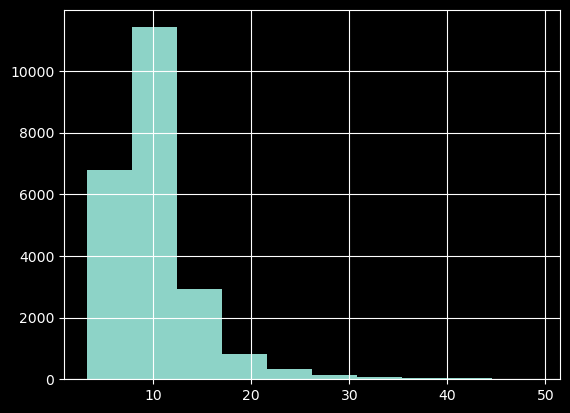

In [144]:
# посмотрим сильно ли изменилось распределение
data['kitchen_area'].hist()


<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы в значениях площади, а также проверил условия, которые указывал в начале проекта и удалил те значения, которые не попали. Восстановил пропуски с помощью total_area, у kitchen_area корреляция phik с ним больше 0.6 

### days_exposition

<Axes: >

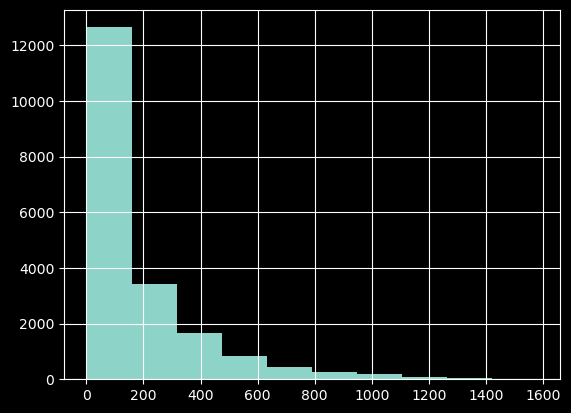

In [145]:
data['days_exposition'].hist()

<Axes: >

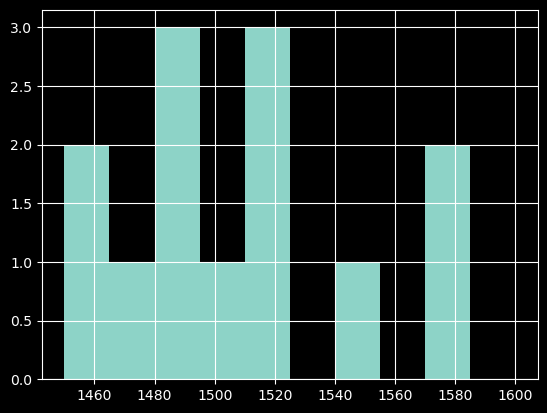

In [146]:
data['days_exposition'].hist(range=(1450, 1600))

In [147]:
# удалим эти выбивающиеся значения

data = data.drop(index=data.query('days_exposition > 1450').index)

<Axes: >

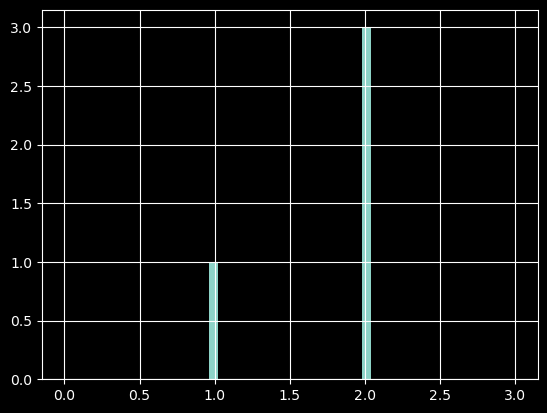

In [148]:
data['days_exposition'].hist(range=(0, 3), bins=50)

In [149]:
data.query('days_exposition <=2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1632,19,4000000.0,49.9,2019-05-01,2,2.5,9.0,25.0,1,False,False,False,10.00,0.0,санкт-петербург,13567.0,14384.0,1.0,20.0,1.0,681.0,1.0
13061,20,6100000.0,51.4,2019-04-29,2,3.0,5.0,31.7,4,False,False,False,6.90,1.0,санкт-петербург,10776.0,9389.0,0.0,NaN,0.0,NaN,2.0
16053,4,4070000.0,45.1,2019-04-30,2,NaN,5.0,22.7,3,False,False,False,6.60,0.0,санкт-петербург,40859.0,11668.0,2.0,485.0,0.0,NaN,2.0
16212,0,7806000.0,25.0,2019-04-30,1,3.0,5.0,17.0,5,0.0,False,False,4.85,0.0,санкт-петербург,36525.0,10302.0,0.0,NaN,0.0,NaN,2.0


In [150]:
# удалим эти выбивающиеся значения
data = data.drop(index=data.query('days_exposition <=2').index)

In [151]:
# чтобы быть объективнее, давай применим коэффициент корреляциия phik, распознающий нелинейные связи и посмотрим
# какие переменные могут помочь точнее определелить значения

# import phik

phik = data.phik_matrix()

interval columns not set, guessing: ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']


C:\ProgramData\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable first_day_exposition is large: 1486. Are you sure this is not an interval variable? Analysis for pairs of variables including first_day_exposition can be slow.
  warnings.warn(


In [152]:
# посмотрим, что влияет на скорость продажи

phik['days_exposition'].sort_values(ascending=False).loc[lambda x: x > 0.1]

days_exposition         1.000000
first_day_exposition    0.830665
total_area              0.181627
living_area             0.173953
cityCenters_nearest     0.162175
kitchen_area            0.134072
airports_nearest        0.115951
Name: days_exposition, dtype: float64

<Axes: >

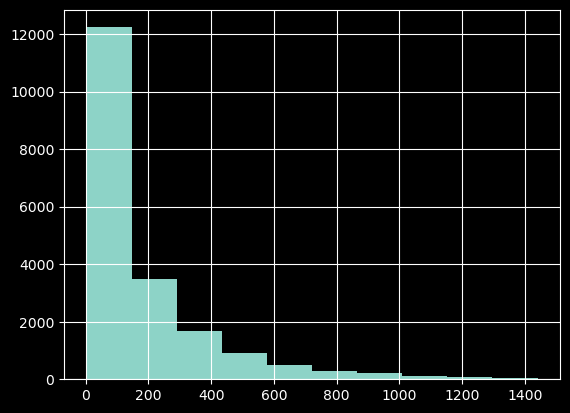

In [153]:
data['days_exposition'].hist()

In [154]:
data['days_exposition'].isna().mean()

0.1339032600992204

### Высота потолков


In [155]:
# Рассмотрим уникальные значения высоты потолков в фиче

In [156]:
sorted(data['ceiling_height'].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.66,
 2.7,
 nan,
 1.2,
 2.25,
 2.34,
 2.46,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.78,
 3.8,
 3.83,
 3.84,
 3.85,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,
 3.98,
 4.0,
 4.06,
 4.1,
 4.14,
 4.15,
 

In [157]:
# меня смущает высота потолка 1 метр, 1.2м,  10.3 м, 14.м и 100м, даже сли учесть, что 10.3 м, 14.м это ~1м и 1.4 м, 
# то все равно эти значения кажутся странными. Аппартаменты с высотой потолков 8 и 8.3 тоже странные наблюдения

# в старых постройках высота могла достигать 5м, возьму с запасом 6м, для элитного жилья. Остальные наблюдения мне 
# напоминают аномалии

# Удаляю наблюдения, где ceiling_height in [1.0, 1.2, 8.0, 8.3, 10.3, 14.0, 100.0]

anomaly = [1.0, 1.2, 8.0, 8.3, 10.3, 14.0, 100.0]
data.query('ceiling_height in @anomaly')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,0.0,False,False,7.3,0.0,нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
5712,5,1500000.0,42.8,2017-08-14,2,1.2,2.0,27.5,1,False,False,False,5.2,0.0,мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,False,False,False,8.3,1.0,санкт-петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14.0,32.4,5,False,False,False,9.1,2.0,санкт-петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,False,False,False,8.0,0.0,санкт-петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,False,False,False,9.0,1.0,красное,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16.0,15.5,15,False,False,False,7.0,0.0,санкт-петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22590,16,6000000.0,55.0,2018-10-31,2,1.0,12.0,32.4,7,False,False,False,10.0,0.0,санкт-петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


In [158]:
# удалю строки с этими значениями

data = data.drop(index=data.query('ceiling_height in @anomaly').index)


In [159]:
# отлично, теперь переведем данные, которые внесли с ошибкой в корректный вид, я говорю про данные
# по типу 24.3м, скорее всего, имели в виду 2.43м высоту потолка, обработаем такие значения


# видим такие аномальные значения 

anomaly = np.array([20.0, 22.6, 24.0, 25.0, 26.0, 27.0, 27.5, 32.0])
anomaly / 10

# чтобы привести их к нормальному виду - достаточно  разделить на 10

array([2.  , 2.26, 2.4 , 2.5 , 2.6 , 2.7 , 2.75, 3.2 ])

In [160]:
# создам словарь, где старые значения будут ключами, а новые - значениями

dict_anomaly = dict(zip(anomaly, np.round(anomaly / 10, 2)))
dict_anomaly

{20.0: 2.0,
 22.6: 2.26,
 24.0: 2.4,
 25.0: 2.5,
 26.0: 2.6,
 27.0: 2.7,
 27.5: 2.75,
 32.0: 3.2}

In [161]:
# теперь заменим старые значения в датафрейме с высотой полотока на новые из словаря

data['ceiling_height'] = data['ceiling_height'].replace(dict_anomaly)

In [162]:
# теперь обработаем пропущенные значения

data['ceiling_height'].isna().mean()

0.38643211627082596

<Axes: >

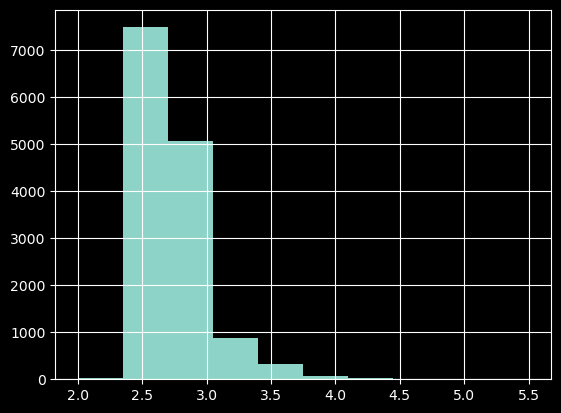

In [163]:
data['ceiling_height'].hist()

<Axes: >

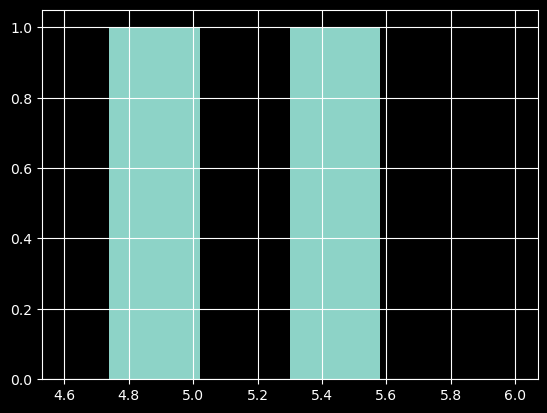

In [164]:
data['ceiling_height'].hist(range=(4.6, 6))

In [165]:
# удалю эти выбросы, значения потолка которых больше 4.6, таких наблюений всего 4

data.query('ceiling_height > 4.6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1053,13,550000.0,29.0,2018-02-01,1,5.0,3.0,15.5,1,0.0,False,False,6.5,0.0,бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2802,7,14950000.0,50.0,2016-03-06,2,4.8,3.0,30.0,2,False,False,False,10.0,0.0,санкт-петербург,24433.0,1725.0,1.0,589.0,3.0,161.0,160.0
7578,17,38000000.0,143.0,2017-11-02,3,5.5,5.0,83.0,5,False,False,False,29.0,1.0,санкт-петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
12628,14,3900000.0,50.0,2018-03-29,1,5.3,5.0,30.0,5,False,False,False,8.0,0.0,санкт-петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0


In [166]:
data = data.drop(index=data.query('ceiling_height > 4.6').index)

In [167]:
data['ceiling_height'].isna().mean()

0.3865006204573657

In [168]:
data['ceiling_height'] = data['ceiling_height']\
                        .fillna(data.groupby('floors_total')['ceiling_height']\
                        .transform('median'))

data['ceiling_height'].isna().mean()

0.0

<Axes: >

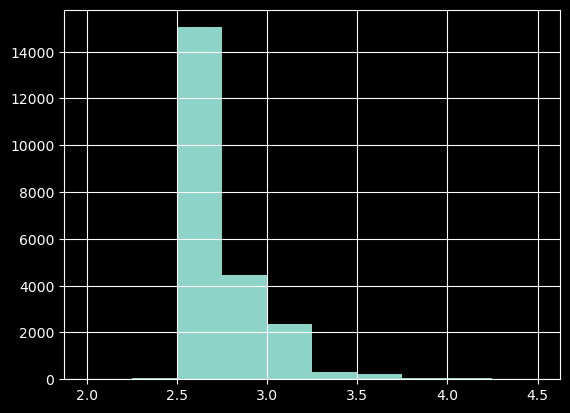

In [169]:
data['ceiling_height'].hist()

# распределение улучшилось по сравнению с тем распрделением, где мы просто прменим медиану ко всей выборке

In [170]:
data.isna().mean().sort_values(ascending=False).loc[lambda x: x!=0]

parks_nearest          0.660920
ponds_nearest          0.618596
airports_nearest       0.232184
cityCenters_nearest    0.231298
ponds_around3000       0.231253
parks_around3000       0.231253
days_exposition        0.133930
dtype: float64

### parks_nearest

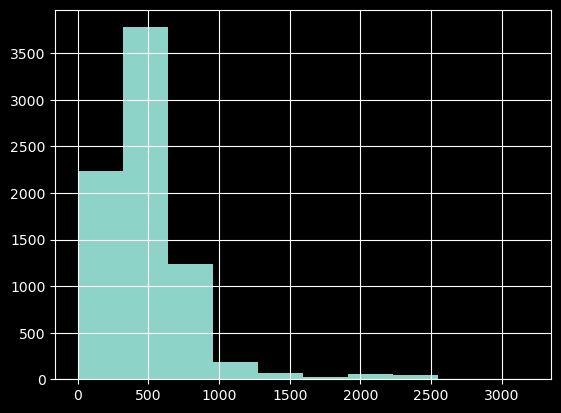

In [171]:
data.parks_nearest.hist();

<Axes: >

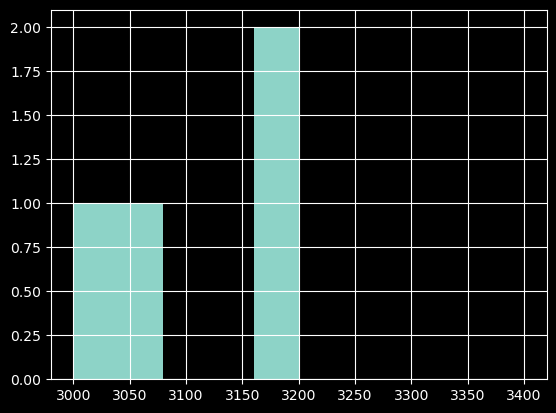

In [172]:
data.parks_nearest.hist(range=(3000, 3400))

In [173]:
data.query('parks_nearest >= 3000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1590,3,7500000.0,70.0,2017-07-11,2,2.70,18.0,37.0,13,False,False,False,10.0,0.0,санкт-петербург,14878.0,9791.0,0.0,3064.0,1.0,264.0,4.0
10959,9,3000000.0,31.1,2017-03-21,1,2.55,5.0,17.7,2,False,False,False,5.5,0.0,санкт-петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0
19208,17,14950000.0,187.0,2017-10-12,5,3.00,2.0,80.0,2,False,False,False,17.0,1.0,санкт-петербург,36805.0,8656.0,0.0,3013.0,3.0,537.0,49.0
19430,9,3900000.0,30.5,2018-02-22,1,2.60,5.0,16.5,1,False,False,False,5.5,0.0,санкт-петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0


In [174]:
# удалю эти аномальные значения, их всего 4

data = data.drop(index=data.query('parks_nearest >= 3000').index)

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы, которые растягивали гистограмму. Полагаю, что заполнять этот параметр не стоит и пропуски лучше оставить, поскольку это картографический параметр и лучше отправить эксперту на перепроверку.

### ponds_nearest

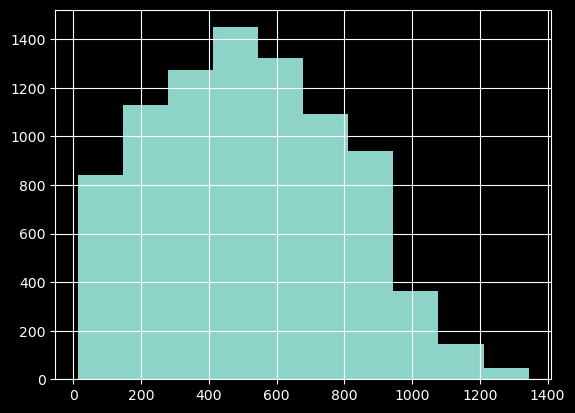

In [175]:
data.ponds_nearest.hist();

<Axes: >

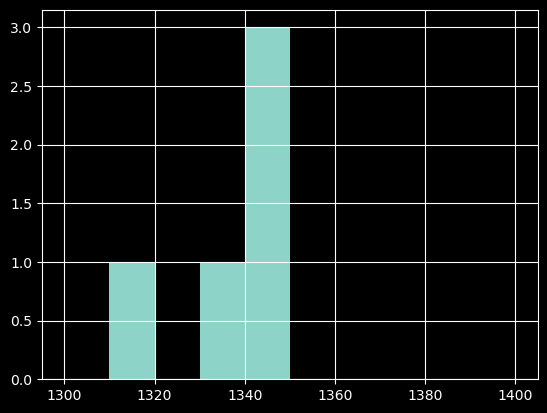

In [176]:
data.ponds_nearest.hist(range=(1300, 1400))

In [177]:
data.query('ponds_nearest >= 1300')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1476,4,6950000.0,66.7,2018-11-14,3,2.65,9.0,42.5,5,False,False,False,8.5,0.0,санкт-петербург,50988.0,16316.0,0.0,NaN,1.0,1337.0,89.0
12054,16,8800000.0,89.0,2018-10-11,3,3.00,5.0,63.9,2,False,False,False,9.2,0.0,санкт-петербург,36488.0,9283.0,0.0,NaN,1.0,1313.0,152.0
19138,20,4200000.0,39.9,2017-10-27,1,2.70,6.0,18.0,6,False,False,False,12.0,1.0,стрельна,28317.0,23506.0,1.0,1069.0,1.0,1341.0,524.0
19924,20,4300000.0,64.7,2016-08-21,2,3.00,6.0,42.2,1,False,False,False,8.8,0.0,стрельна,28317.0,23506.0,1.0,1069.0,1.0,1341.0,544.0
20726,7,3250000.0,35.0,2018-08-30,1,2.55,7.0,16.4,1,False,False,False,7.8,0.0,стрельна,28377.0,23562.0,1.0,1073.0,1.0,1344.0,81.0


In [178]:
# удалю эти аномальные значения, их всего 4

data = data.drop(index=data.query('ponds_nearest >= 1300').index)

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы, которые растягивали гистограмму. Полагаю, что заполнять этот параметр не стоит и пропуски лучше оставить, поскольку это картографический параметр и лучше отправить эксперту на перепроверку.

### airports_nearest

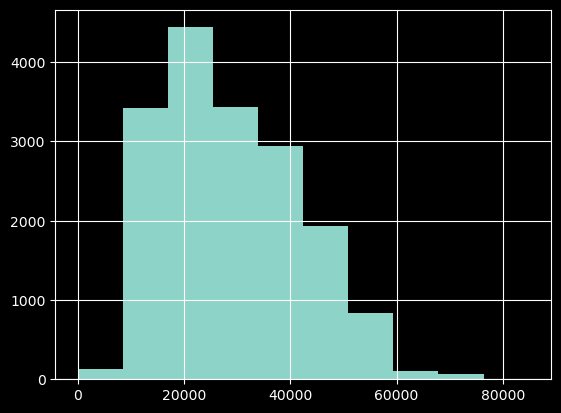

In [179]:
data.airports_nearest.hist();

<Axes: >

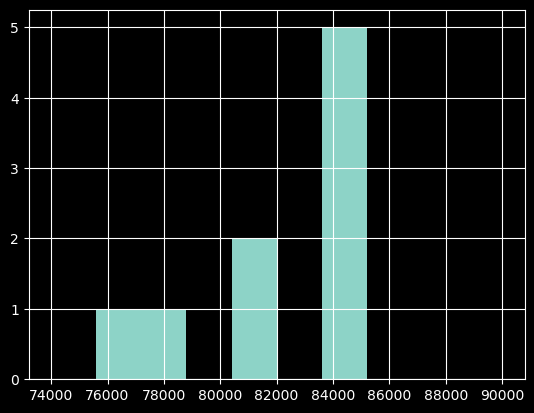

In [180]:
data.airports_nearest.hist(range=(74000, 90000))

In [181]:
data.query('airports_nearest >= 74000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
577,7,4000000.0,59.0,2017-07-23,3,2.50,5.0,37.0,1,0.0,False,False,7.0,0.0,молодёжное,84665.0,65764.0,0.0,NaN,0.0,NaN,NaN
939,17,3015000.0,31.2,2019-04-16,1,2.50,3.0,17.5,1,False,False,False,5.8,0.0,зеленогорск,75646.0,56745.0,0.0,NaN,1.0,347.0,NaN
2974,13,3200000.0,46.3,2018-03-31,2,2.50,3.0,29.2,2,False,False,False,7.0,1.0,зеленогорск,81355.0,62454.0,0.0,NaN,0.0,NaN,205.0
4441,6,2300000.0,31.0,2016-05-26,1,2.80,3.0,12.0,1,False,False,False,9.0,0.0,зеленогорск,78527.0,59626.0,0.0,NaN,0.0,NaN,232.0
5218,15,3650000.0,53.8,2018-09-24,3,2.50,4.0,36.9,3,False,False,False,5.2,0.0,молодёжное,83758.0,64857.0,0.0,NaN,0.0,NaN,121.0
5340,19,3600000.0,50.6,2019-03-19,2,2.50,5.0,29.9,4,False,False,False,7.0,1.0,молодёжное,84853.0,65952.0,0.0,NaN,0.0,NaN,NaN
9640,8,4200000.0,51.4,2014-12-10,2,2.55,5.0,31.0,2,False,False,False,6.0,1.0,молодёжное,84869.0,65968.0,0.0,NaN,0.0,NaN,1194.0
18884,15,3600000.0,57.6,2019-02-08,3,2.55,3.0,41.3,2,False,False,False,6.5,1.0,зеленогорск,81607.0,62706.0,0.0,NaN,0.0,NaN,13.0
20746,1,3300000.0,43.5,2016-02-16,2,2.55,4.0,27.2,2,False,False,False,5.0,1.0,молодёжное,84006.0,65105.0,0.0,NaN,0.0,NaN,1043.0


In [182]:
# удалю эти аномальные значения, их всего 9

data = data.drop(index=data.query('airports_nearest >= 74000').index)

<Axes: >

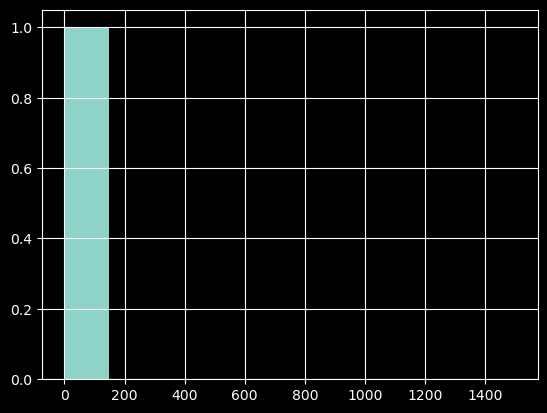

In [183]:
# видим еще одну аномалию, удалим ее
data.airports_nearest.hist(range=(0, 1500))

In [184]:
data = data.drop(index=data.query('airports_nearest < 1400').index)

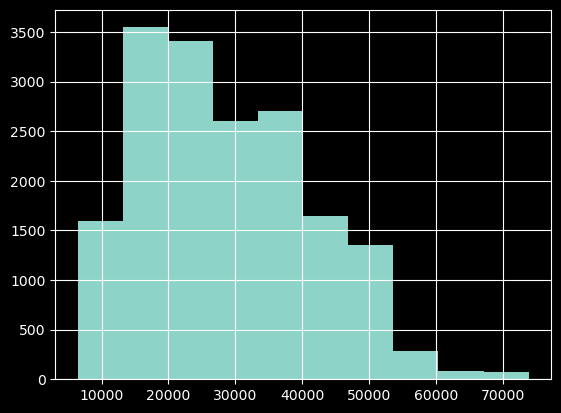

In [185]:
data.airports_nearest.hist();

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы, которые растягивали гистограмму. Полагаю, что заполнять этот параметр не стоит и пропуски лучше оставить, поскольку это картографический параметр и лучше отправить эксперту на перепроверку.

### cityCenters_nearest

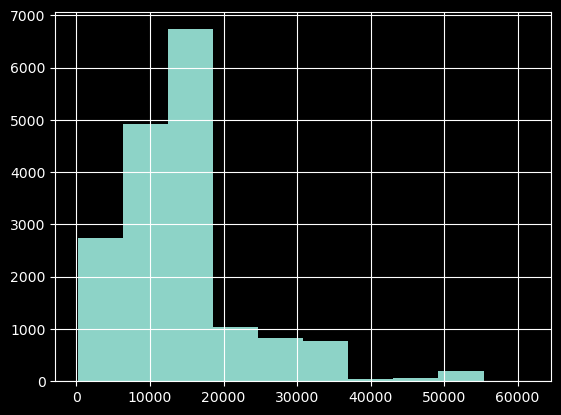

In [186]:
data.cityCenters_nearest.hist();

<Axes: >

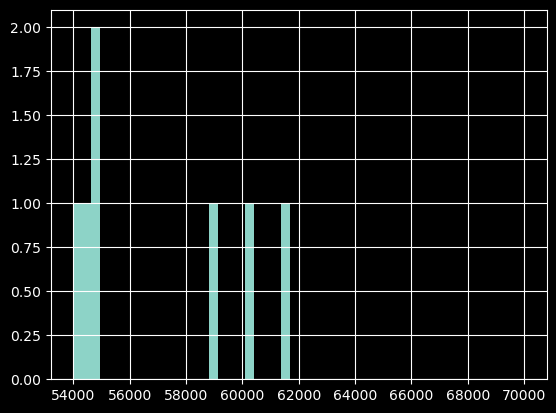

In [187]:
data.cityCenters_nearest.hist(range=(54000, 70000), bins=50)

In [188]:
data.query('cityCenters_nearest >= 54000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
376,18,8400000.0,84.0,2018-06-26,2,2.75,3.0,41.0,1,False,False,False,13.0,0.0,зеленогорск,73827.0,54926.0,0.0,NaN,0.0,NaN,201.0
6247,8,9600000.0,180.1,2017-03-07,4,2.75,2.0,100.0,2,False,False,False,19.5,1.0,зеленогорск,73547.0,54646.0,0.0,NaN,1.0,1037.0,496.0
11244,8,4250000.0,32.0,2018-02-04,1,2.70,2.0,20.0,2,False,False,False,7.0,0.0,зеленогорск,72713.0,59052.0,3.0,148.0,1.0,671.0,24.0
16569,13,3200000.0,52.8,2017-06-20,2,2.55,5.0,29.9,3,False,False,False,8.3,0.0,ломоносов,53042.0,61495.0,2.0,223.0,0.0,NaN,240.0
22855,16,2950000.0,31.0,2018-03-07,1,2.70,1.0,16.4,1,False,False,False,5.6,0.0,зеленогорск,73115.0,54214.0,3.0,188.0,1.0,269.0,328.0
22941,8,10965000.0,69.3,2019-01-10,1,3.00,4.0,48.9,4,1.0,False,False,11.4,2.0,зеленогорск,73391.0,54490.0,3.0,4.0,1.0,217.0,110.0
23123,0,1800000.0,32.0,2018-07-17,1,2.70,2.0,17.0,1,False,False,False,6.0,0.0,ломоносов,56896.0,60223.0,1.0,17.0,0.0,NaN,147.0


In [189]:
# удалю эти аномальные значения, их всего 9

data = data.drop(index=data.query('cityCenters_nearest >= 54000').index)

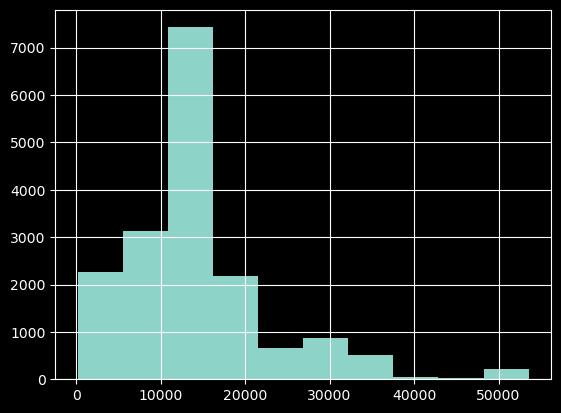

In [190]:
data.cityCenters_nearest.hist();

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Удалил выбросы, которые растягивали гистограмму. Полагаю, что заполнять этот параметр не стоит и пропуски лучше оставить, поскольку это картографический параметр и лучше отправить эксперту на перепроверку.

### ponds_around3000

In [191]:
data.ponds_around3000.value_counts()
# здесь аномальных значений нет

0.0    8728
1.0    5434
2.0    1785
3.0    1373
Name: ponds_around3000, dtype: int64

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Аномальных значений не вижу. Картографический пропуск лучше отправить на доработку

### parks_around3000

In [192]:
data.parks_around3000.value_counts()
# здесь аномальных значений нет

0.0    9681
1.0    5450
2.0    1609
3.0     580
Name: parks_around3000, dtype: int64

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Аномальных значений не вижу. Картографический пропуск лучше отправить на доработку

### Оставшиеся переменные

In [193]:
data.isna().mean().sort_values(ascending=False).loc[lambda x: x != 0]

parks_nearest          0.661061
ponds_nearest          0.618777
airports_nearest       0.232452
cityCenters_nearest    0.231564
ponds_around3000       0.231520
parks_around3000       0.231520
days_exposition        0.133952
dtype: float64

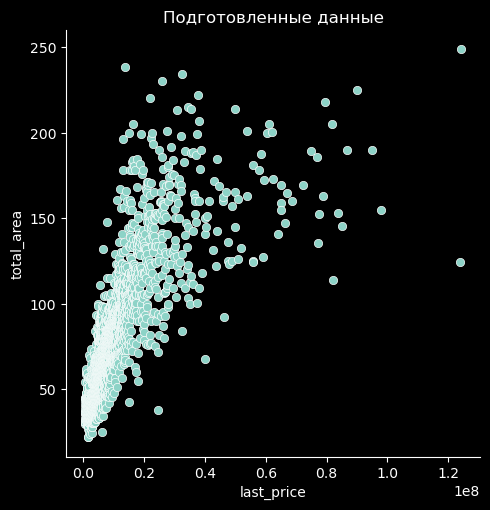

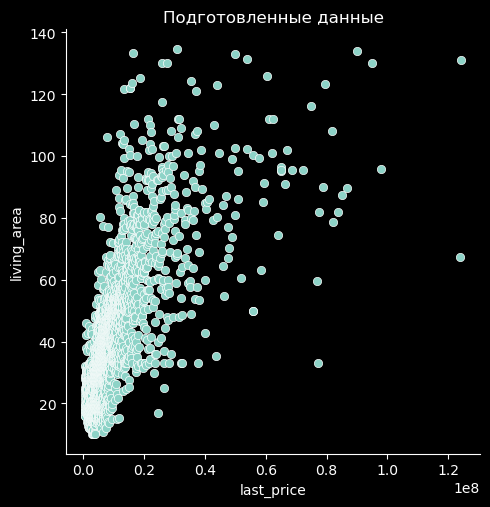

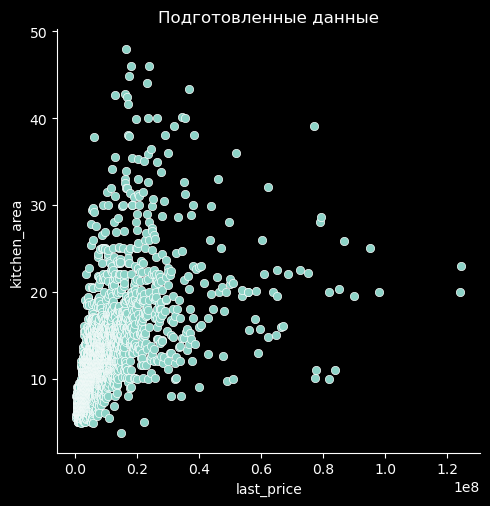

In [194]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')
    plt.title('Подготовленные данные')

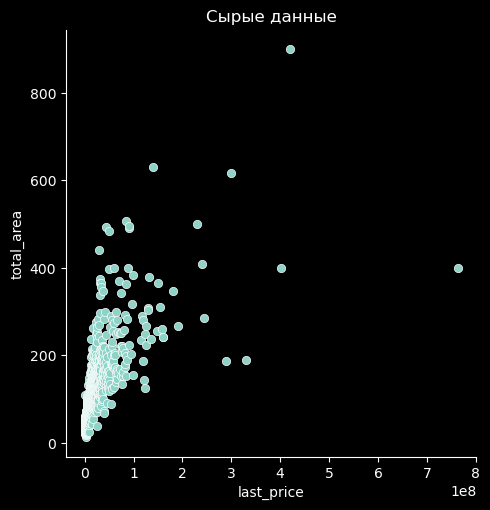

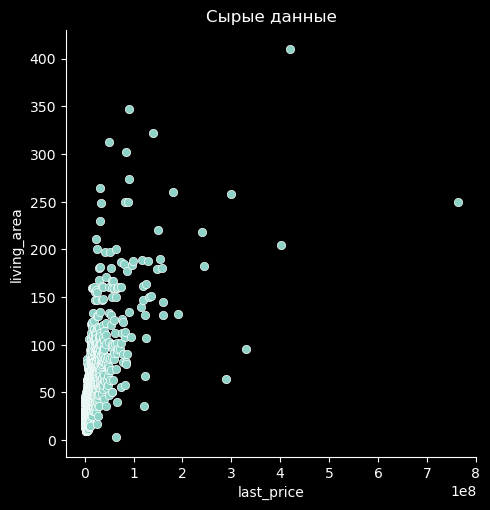

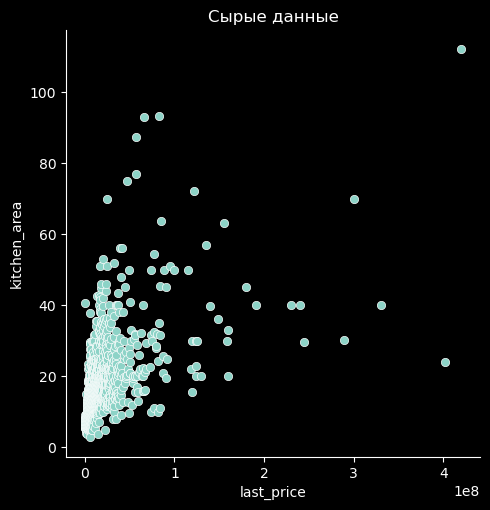

In [195]:
# check

row_data =  pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
price_pivot_area = row_data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')
    plt.title('Сырые данные')

## Природа пропусков

**Пропуски** — тоже важный сигнал, который нужно учитывать. 

**Восстановил все пропуски, кроме картографических, их заполнение даст сильно искажение, лучше отправить их на доработку. Природа пропусков days_exposition - это сигнал того, что объявление еще активно и недвижимость висит в продаже.**


Если говорить о природе пропусков, то могу предположить, что это либо ошибки системы при выгрузке с базы данных, либо переброса информации из одной базы в другую. Также в одной базе данных данные могли быть представлены другим типом, в другой базе и была ошибка совместимости. Еще это могли быть ошибки при заполнении объявления(например, пользователь не указал 0 балконов, поскольку у него их нет, а это привело к пропускам). Ошибки при получения картографических данных со спутника. Повторное изменение данных пользователем. Варинтов может быть очень много. 

**Переменные, указанные выше стоит отправить на проверку экспертам.**

In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22538 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22538 non-null  int64         
 1   last_price            22538 non-null  float64       
 2   total_area            22538 non-null  float64       
 3   first_day_exposition  22538 non-null  datetime64[ns]
 4   rooms                 22538 non-null  int64         
 5   ceiling_height        22538 non-null  float64       
 6   floors_total          22538 non-null  float64       
 7   living_area           22538 non-null  float64       
 8   floor                 22538 non-null  int64         
 9   is_apartment          22538 non-null  object        
 10  studio                22538 non-null  bool          
 11  open_plan             22538 non-null  bool          
 12  kitchen_area          22538 non-null  float64       
 13  balcony         

**Переведу следующие переменные:***
* is_apartment -> bool
* floor -> int
* floors_total -> int
* rooms -> int


In [197]:
data.is_apartment = data.is_apartment.astype('bool')

In [198]:
data[['is_apartment', 'floor', 'floors_total', 'rooms']].isna().mean()

is_apartment    0.0
floor           0.0
floors_total    0.0
rooms           0.0
dtype: float64

In [199]:
data.floor = data.floor.astype('int')

In [200]:
data.floors_total = data.floors_total.astype('int')

In [201]:
data.rooms = data.rooms.astype('int')

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22538 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22538 non-null  int64         
 1   last_price            22538 non-null  float64       
 2   total_area            22538 non-null  float64       
 3   first_day_exposition  22538 non-null  datetime64[ns]
 4   rooms                 22538 non-null  int32         
 5   ceiling_height        22538 non-null  float64       
 6   floors_total          22538 non-null  int32         
 7   living_area           22538 non-null  float64       
 8   floor                 22538 non-null  int32         
 9   is_apartment          22538 non-null  bool          
 10  studio                22538 non-null  bool          
 11  open_plan             22538 non-null  bool          
 12  kitchen_area          22538 non-null  float64       
 13  balcony         

In [203]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

# (
#     data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
#           'floor', 'floors_total']]
#     .apply (['count', 'min', 'max'])   
#     .style.format("{:,.2f}")
# )

(
    data[['total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area
count,"22,538.00","22,538.00","19,519.00","22,538.00","22,538.00","22,538.00"
min,21.00,2.00,3.00,"500,000.00",10.00,3.20
max,250.00,4.50,"1,441.00","124,350,000.00",139.80,49.20


In [204]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,7745
2,7726
3,5616
4,1105
5,262
6,61
7,23


In [205]:
data.total_area.value_counts().to_frame()

,total_area
45.00,409
42.00,368
31.00,340
60.00,338
44.00,337
...,...
29.54,1
45.69,1
35.24,1
130.21,1


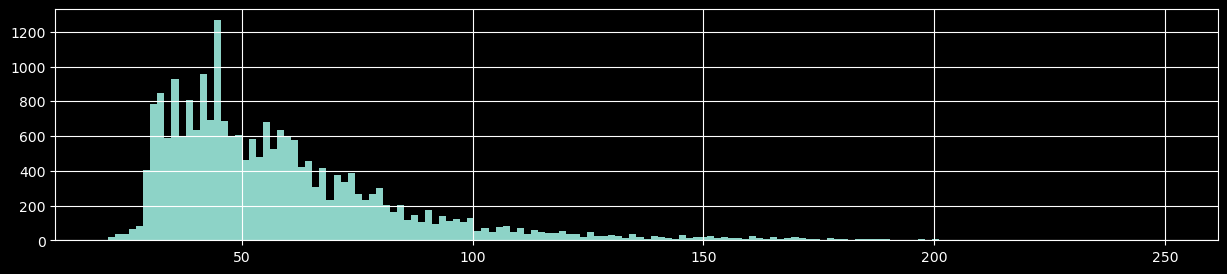

In [206]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

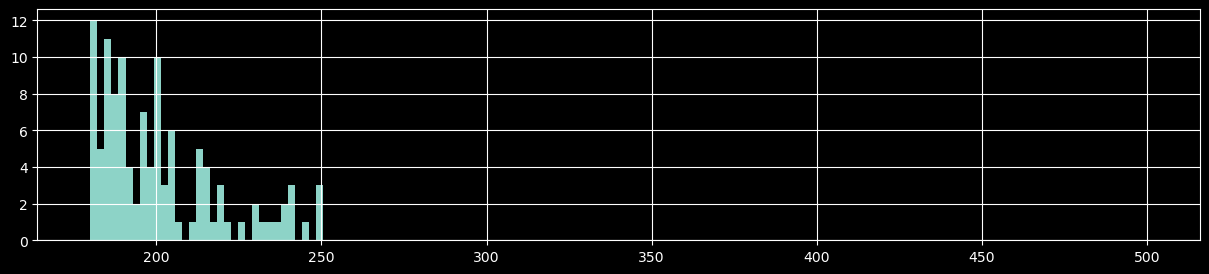

In [207]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

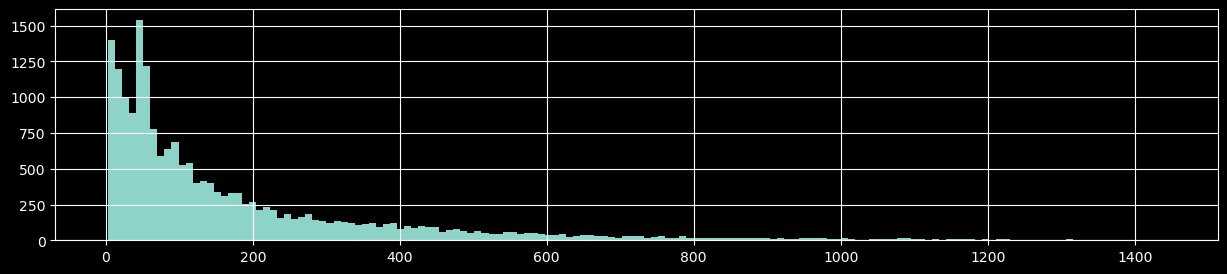

In [208]:
# check
data.days_exposition.hist(bins = 150, figsize = (15,3));

In [209]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area
0.010000,28.60,2.50,4.00,"1,050,000.00",13.50,5.00
0.500000,52.00,2.65,95.00,"4,630,000.00",30.00,9.00
0.900000,91.00,3.00,456.00,"10,499,000.00",53.20,15.00
0.997600,197.00,4.00,"1,258.25","48,695,245.60",119.99,40.00


In [210]:
data['rooms'].quantile(0.1)

1.0

### Feature Engeenering

#### Цена одного квадратного метра

In [211]:
# цену одного квадратного метра можно расчитать поделив стоимость объекта на его общую площадь

In [212]:
data['price_one_square meter'] = data['last_price'] / data['total_area']

#### День недели публикации

In [213]:
# The day of the week with Monday=0, Sunday=6.
data['first_day_exposition'].dt.dayofweek


0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: first_day_exposition, Length: 22538, dtype: int64

In [214]:
data['day_of_week_publication'] = data['first_day_exposition'].dt.dayofweek

#### Месяц публикации объявления


In [215]:
data['month_of_publication'] = data['first_day_exposition'].dt.month

#### Год публикации объявления

In [216]:
data['year_of_publication'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры

In [217]:
def type_floor(row):
    floor = abs(row['floor'])
    floors_total = abs(row['floors_total'])
    if floor == 1 or floor == 0:
        return "первый"
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    

# elif 1 < floor < floors_total:

In [218]:
data.apply(type_floor, axis=1).head(15)

0        другой
1        первый
2        другой
3        другой
4        другой
5        другой
6        другой
7        другой
8        другой
9        другой
10       другой
11       другой
12    последний
13    последний
14       первый
dtype: object

In [219]:
# теперь добавим в основной датафрейм

In [220]:
data['type_floors'] = data.apply(type_floor, axis=1)

### Расстояние до центра города в километрах

In [221]:
data['cityCenters_nearest']

0        16028.0
1        18603.0
2        13933.0
3         6800.0
4         8098.0
          ...   
23694     4232.0
23695        NaN
23696        NaN
23697    10364.0
23698        NaN
Name: cityCenters_nearest, Length: 22538, dtype: float64

In [222]:
(data['cityCenters_nearest'] / 1000).round()

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest, Length: 22538, dtype: float64

In [223]:
data['cityCenters_nearest_to_km'] = (data['cityCenters_nearest'] / 1000).round()

In [224]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square meter,day_of_week_publication,month_of_publication,year_of_publication,type_floors,cityCenters_nearest_to_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.00,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.75,11,18.600000,1,False,False,False,11.00,2.0,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.55,5,34.300000,4,False,False,False,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.60,14,95.000000,9,False,False,False,15.00,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.00,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,False,False,False,13.83,0.0,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490.845228,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.55,5,38.000000,4,False,False,False,8.50,0.0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542.372881,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.80,3,29.700000,1,False,False,False,8.40,0.0,рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091.710758,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,33.197356,12,False,False,False,23.30,2.0,санкт-петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511.400651,1,3,2017,другой,10.0


## Исследовательский анализ данных

In [225]:
# После восстановления данных, поиска аномалий и добавления новых фичей, займемся EDA

#### Общая площадь

In [226]:
data['total_area']

0        108.00
1         40.40
2         56.00
3        159.00
4        100.00
          ...  
23694    133.81
23695     59.00
23696     56.70
23697     76.75
23698     32.30
Name: total_area, Length: 22538, dtype: float64

Text(0.5, 0, 'Площадь')

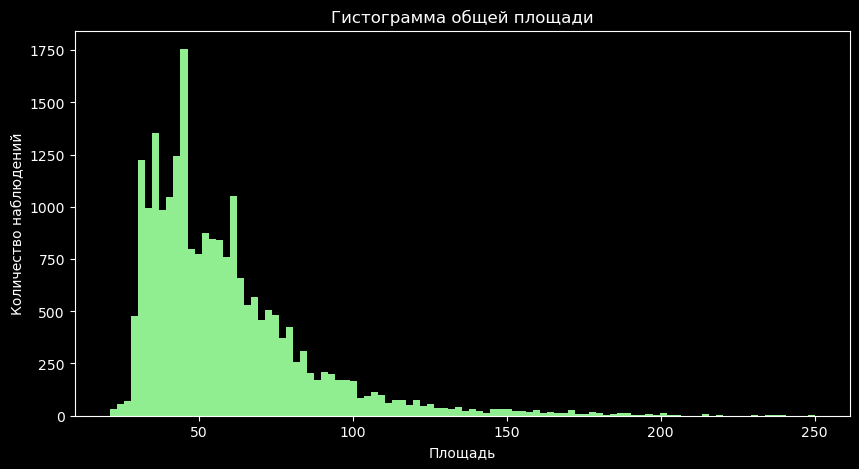

In [227]:
# Видим в распрделении жирный хвост

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['total_area'].plot(kind='hist', bins=100, color='lightgreen')
plt.title('Гистограмма общей площади')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь')

Text(0.5, 0, 'Площадь')

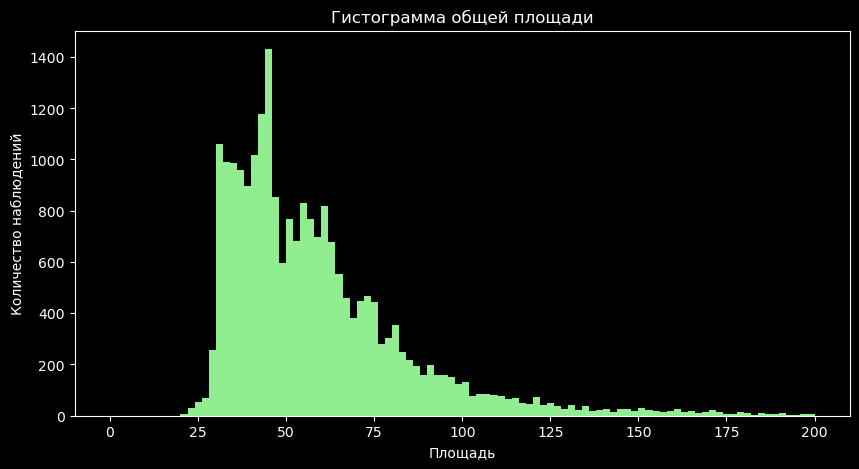

In [228]:
# ограничимся диапазоном (0, 200), далее у нас идут редкие значения

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['total_area'].plot(kind='hist', bins=100, range=(0, 200), color='lightgreen')
plt.title('Гистограмма общей площади')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь')

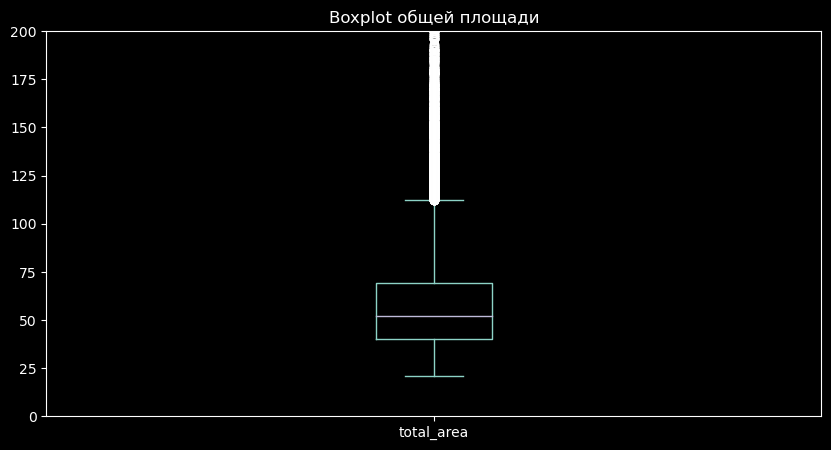

In [229]:
data['total_area'].plot(kind='box', ylim=(0, 200))
plt.title('Boxplot общей площади');

# белой линией мы наблюдаем большое количество выбросов, находящихся за "зоной нормальных значений"

In [230]:
# смотрим основные описательные статистики
data['total_area'].describe()

count    22538.000000
mean        58.634283
std         26.936125
min         21.000000
25%         40.200000
50%         52.000000
75%         69.000000
max        250.000000
Name: total_area, dtype: float64

**ВЫВОД:** Видим, что в распрделении у нас есть жирный хвост, который является следствием редких крупных значений признака.
Средняя общая площадь 58.6
Медиана 52


Стандартное отклонение, в целом, большое 26 


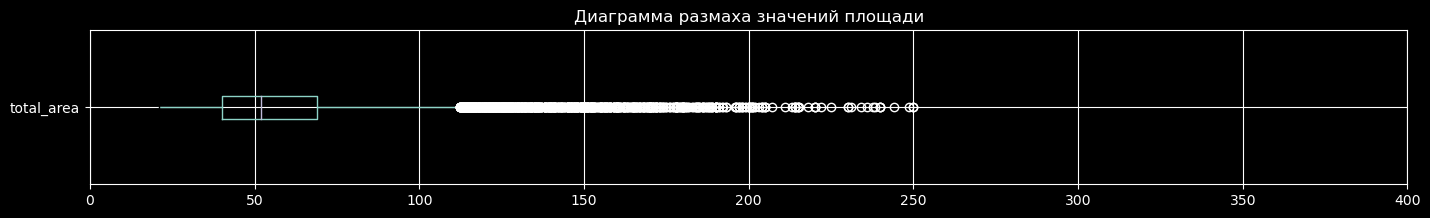

In [231]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

#### Жилая площадь

In [232]:
data['living_area']

0        51.000000
1        18.600000
2        34.300000
3        95.000000
4        32.000000
           ...    
23694    73.300000
23695    38.000000
23696    29.700000
23697    33.197356
23698    12.300000
Name: living_area, Length: 22538, dtype: float64

Text(0.5, 0, 'Площадь')

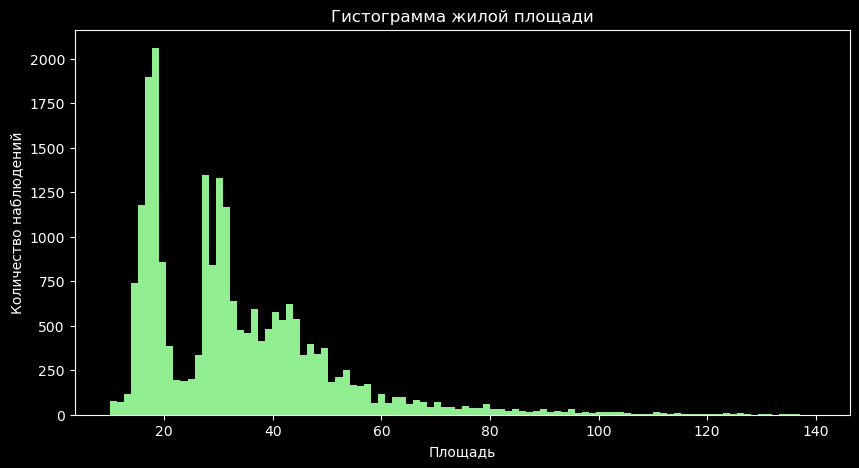

In [233]:
# Видим в распрделении жирный хвост

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['living_area'].plot(kind='hist', bins=100, color='lightgreen')
plt.title('Гистограмма жилой площади')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь')

Text(0.5, 0, 'Площадь')

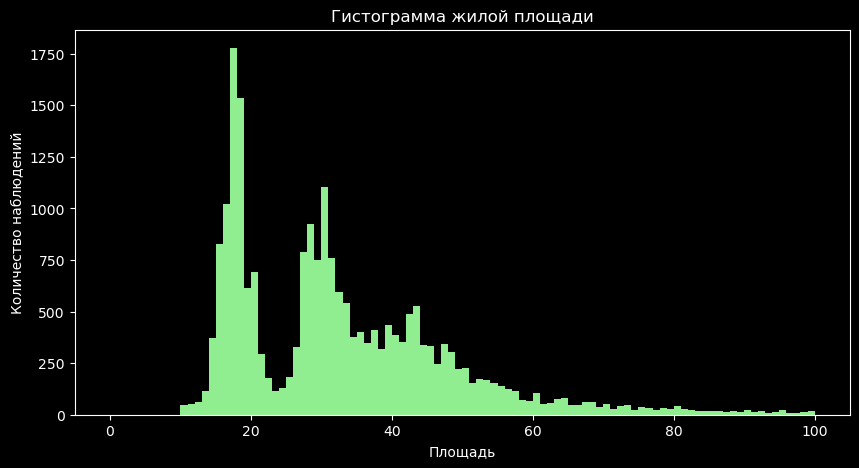

In [234]:
# ограничимся диапазоном (0, 100), далее у нас идут редкие значения

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['living_area'].plot(kind='hist', bins=100, range=(0, 100), color='lightgreen')
plt.title('Гистограмма жилой площади')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь')

Text(0.5, 1.0, 'Boxplot жилой площади')

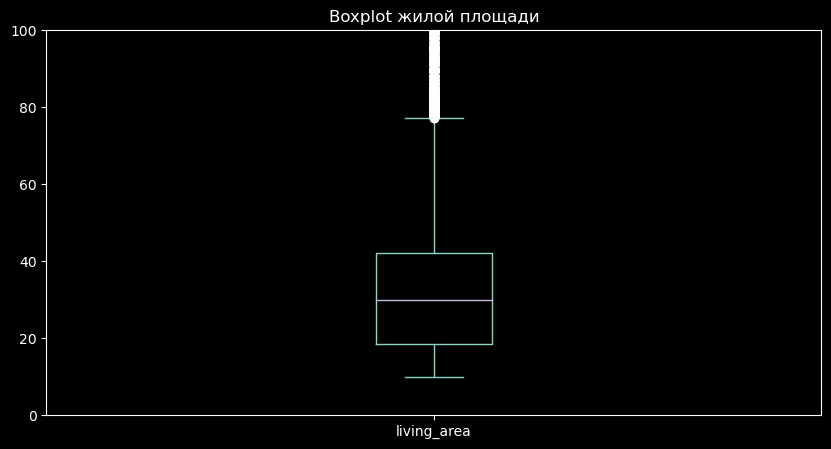

In [235]:
data['living_area'].plot(kind='box', ylim=(0, 100))
plt.title('Boxplot жилой площади')

# белой линией мы наблюдаем большое количество выбросов, находящихся за "зоной нормальных значений"

In [236]:
# смотрим основные описательные статистики
data['living_area'].describe()

count    22538.000000
mean        33.253069
std         17.149254
min         10.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        139.800000
Name: living_area, dtype: float64

**ВЫВОД:** Видим, что в распрделении у нас есть жирный хвост, который является следствием редких крупных значений признака.
Средняя  площадь 33.2
Медиана  30.
Стандартное отклонение, в целом, большое 17




#### Площадь кухни

In [237]:
data['kitchen_area']

0        25.00
1        11.00
2         8.30
3        15.00
4        41.00
         ...  
23694    13.83
23695     8.50
23696     8.40
23697    23.30
23698     9.00
Name: kitchen_area, Length: 22538, dtype: float64

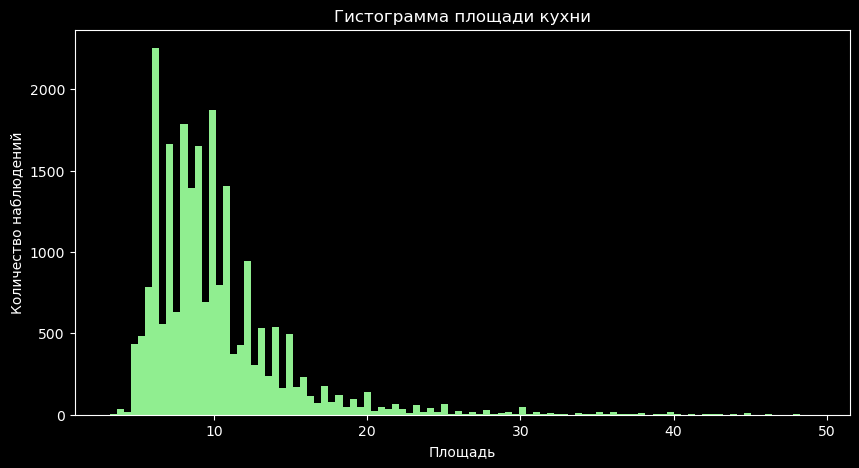

In [238]:
# Видим в распрделении жирный хвост

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['kitchen_area'].plot(kind='hist', bins=100, color='lightgreen')
plt.title('Гистограмма площади кухни')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь');

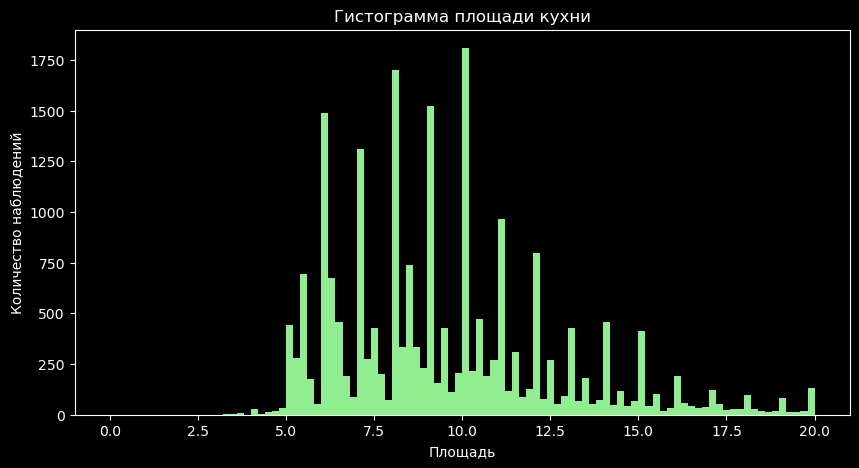

In [239]:
# ограничимся диапазоном (0, 20), далее у нас идут редкие значения

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['kitchen_area'].plot(kind='hist', bins=100, range=(0, 20), color='lightgreen')
plt.title('Гистограмма площади кухни')
plt.ylabel('Количество наблюдений')
plt.xlabel('Площадь');

In [240]:
# Видим пики на гистограмме, давай выведем топ-10 самых частых значений, чтобы рассмотреть их

data['kitchen_area'].value_counts().sort_values(ascending=False).head(10)


10.0    1403
6.0     1367
9.0     1307
8.0     1254
7.0     1131
11.0     799
12.0     659
8.5      501
5.5      407
14.0     381
Name: kitchen_area, dtype: int64

Text(0.5, 1.0, 'BOXPLOT площади кухни')

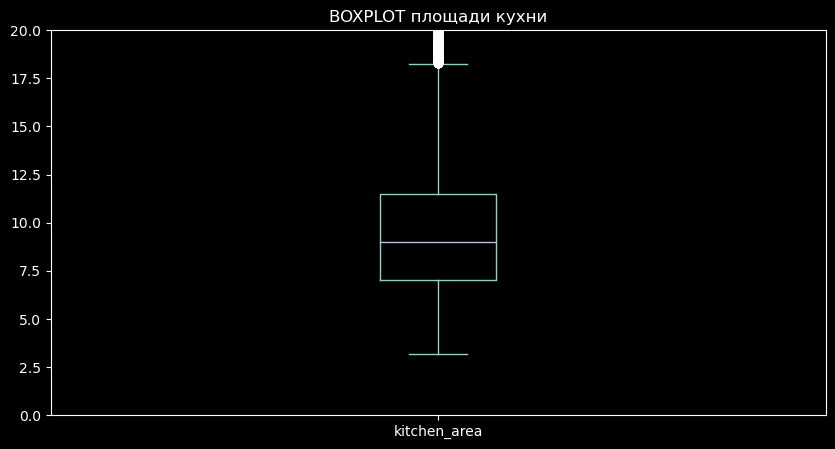

In [241]:
data['kitchen_area'].plot(kind='box', ylim=(0, 20))
plt.title('BOXPLOT площади кухни')

# белой линией мы наблюдаем большое количество выбросов, находящихся за "зоной нормальных значений"

In [242]:
# смотрим основные описательные статистики
data['kitchen_area'].describe()

count    22538.000000
mean        10.132040
std          4.676098
min          3.200000
25%          7.000000
50%          9.000000
75%         11.500000
max         49.200000
Name: kitchen_area, dtype: float64

**ВЫВОД:** Видим, что в распрделении у нас есть жирный хвост, который является следствием редких крупных значений признака.
Средняя площадь 10.1
Медиана 9
Стандартное отклонение, в целом, небольшое 4.6


#### Цена объекта

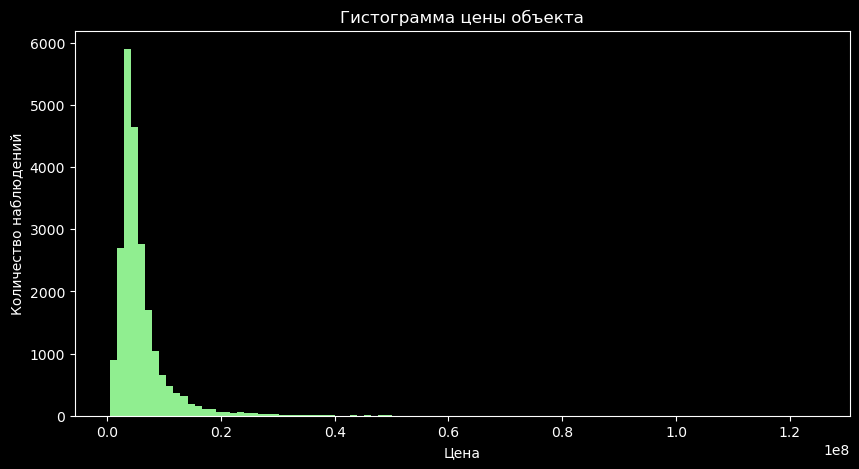

In [243]:
# Видим в распрделении жирный хвост

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['last_price'].plot(kind='hist', bins=100, color='lightgreen')
plt.title('Гистограмма цены объекта')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена');

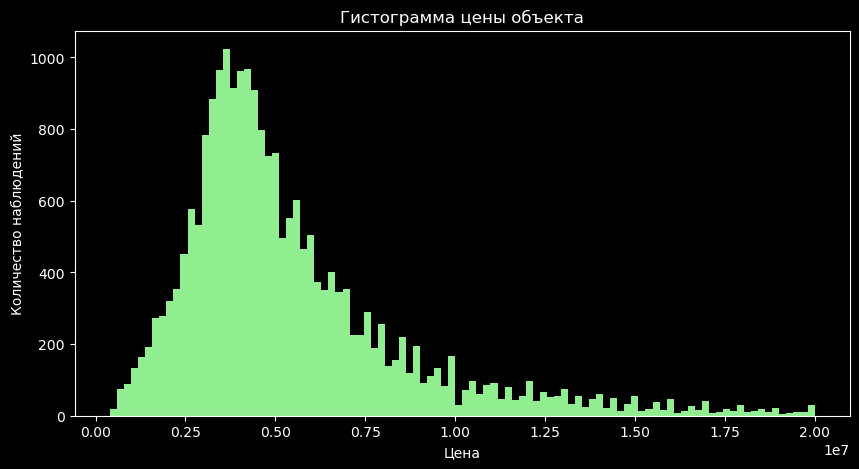

In [244]:
# ограничимся диапазоном (400к, 200млн), далее у нас идут редкие значения

plt.rcParams['figure.figsize']=(10,5) # изменение размера
data['last_price'].plot(kind='hist', bins=100, range=(400000, 20000000), color='lightgreen')
plt.title('Гистограмма цены объекта')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена');

# видим, что большинство объектов имеют цену до 100 млн, также есть отдельные крупные объекты по цене

In [245]:

data['last_price'].describe()


count    2.253800e+04
mean     6.007047e+06
std      5.464433e+06
min      5.000000e+05
25%      3.450000e+06
50%      4.630000e+06
75%      6.700000e+06
max      1.243500e+08
Name: last_price, dtype: float64

In [246]:
# добавим еще один столбец, разобьем цену объекта на группы, чтобы далее было легче группировать

* 300к - 4 млн - дешево
* 4 млн - 30 - средняя
* 30 - 80 - дорогая
* > 80 - элитная

In [247]:
def type_price(col):
    if col < 4000000:
        return 'дешевая'
    
    elif col >= 4000000 and col < 30000000:
        return 'средняя'
    
    elif col >= 30000000 and col < 80000000:
        return 'дорогая'
    
    else:
        return 'элитная'

In [248]:
data['type_price'] = data['last_price'].apply(type_price)

In [249]:
data[['last_price', 'type_price']]

# катгоризация прошла

,last_price,type_price
0,13000000.0,средняя
1,3350000.0,дешевая
2,5196000.0,средняя
3,64900000.0,дорогая
4,10000000.0,средняя
...,...,...
23694,9700000.0,средняя
23695,3100000.0,дешевая
23696,2500000.0,дешевая
23697,11475000.0,средняя


**ВЫВОД:**  Видим, что в распрделении у нас есть жирный хвост, который является следствием редких крупных значений признака.
Средняя цена 6.006956e+06
Медиана 50%  4.630000e+06

Стандартное отклонение, огромное из-за жирного хвоста 5.4млн



#### Количество комнат

In [250]:
data['rooms'].value_counts()

# самое частое значение 2 комнаты

1    7745
2    7726
3    5616
4    1105
5     262
6      61
7      23
Name: rooms, dtype: int64

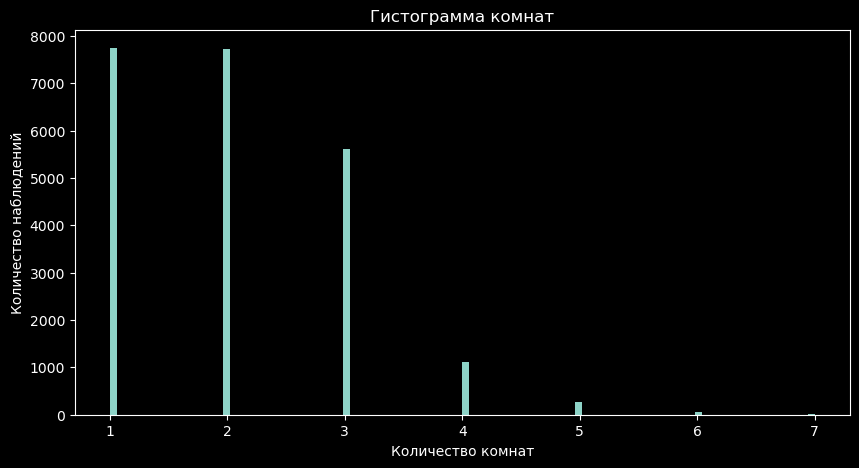

In [251]:

data['rooms'].astype('int').plot(kind='hist', bins=100)
plt.title('Гистограмма комнат')
plt.ylabel('Количество наблюдений')
plt.xlabel('Количество комнат');



In [252]:
# выведем описательную статистику
data['rooms'].astype('int').describe()

count    22538.000000
mean         2.054397
std          0.979519
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

**ВЫВОД:**  Максимальное количество комнат 7, самое частое наблюдение - 2 комнаты. 


#### Высота потолков

In [253]:
data['ceiling_height']

0        2.70
1        2.75
2        2.55
3        2.60
4        3.03
         ... 
23694    3.70
23695    2.55
23696    2.80
23697    3.00
23698    2.50
Name: ceiling_height, Length: 22538, dtype: float64

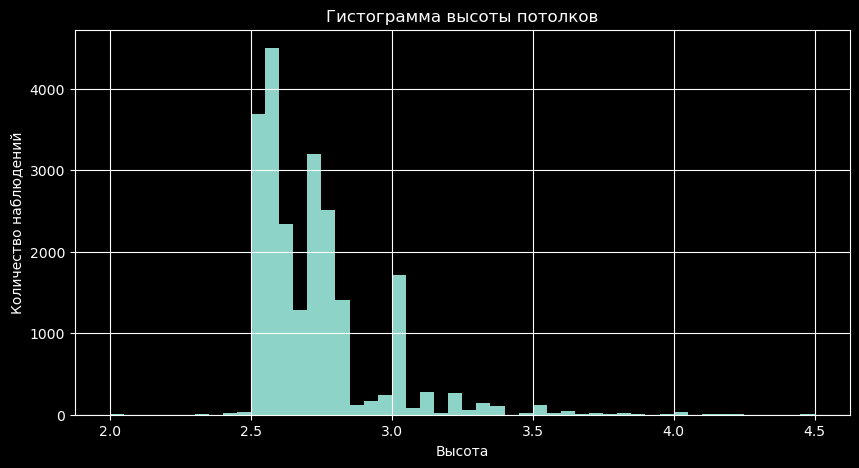

In [254]:
# видим хвосты у распрделения с двух сторон
data['ceiling_height'].hist(bins=50)
plt.title('Гистограмма высоты потолков')
plt.ylabel('Количество наблюдений')
plt.xlabel('Высота');

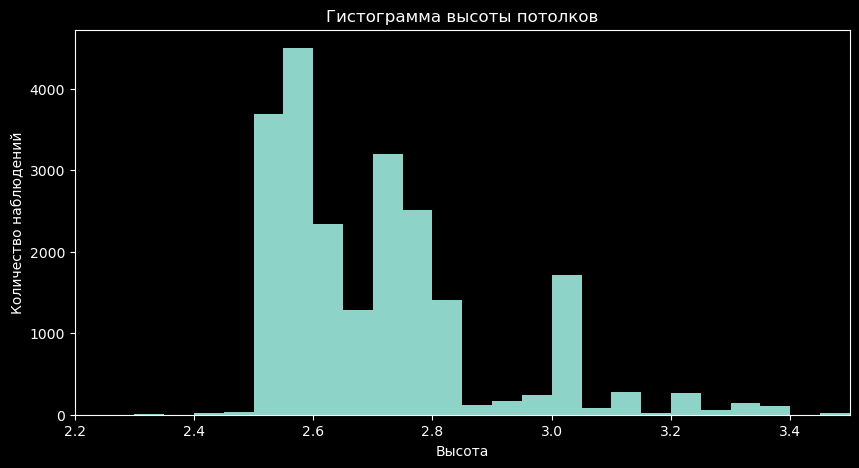

In [255]:
# рассмторим гистограмму без хвостов
data['ceiling_height'].plot(kind='hist', xlim=(2.2, 3.5), bins=50)
plt.title('Гистограмма высоты потолков')
plt.ylabel('Количество наблюдений')
plt.xlabel('Высота');
# Видим, что центре собраны самые частотные значения

In [256]:
# 2.55 м самое популярное значение
data['ceiling_height'].value_counts()

2.55    4185
2.50    3434
2.70    3017
2.75    2338
2.60    2229
        ... 
4.30       1
3.39       1
4.40       1
3.85       1
3.59       1
Name: ceiling_height, Length: 152, dtype: int64

In [257]:
data['ceiling_height'].describe()

count    22538.000000
mean         2.699879
std          0.218831
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          4.500000
Name: ceiling_height, dtype: float64

In [258]:
data['ceiling_height'].value_counts().head()

2.55    4185
2.50    3434
2.70    3017
2.75    2338
2.60    2229
Name: ceiling_height, dtype: int64

**ВЫВОД:** Самое популярное значение 2.55м, минимальное значение 2м, максимальное значение высоты потолка 4.5м.
Самые популрные значения лежат в промежутке от 2.55 до 3 м.


#### Этаж квартиры

In [259]:
data['floor'].value_counts().head(7)

2    3197
3    2935
1    2755
4    2674
5    2493
6    1244
7    1165
Name: floor, dtype: int64

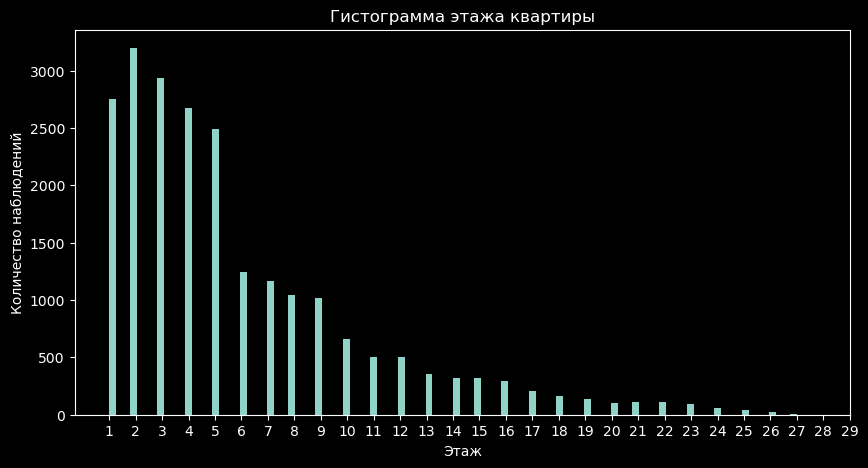

In [260]:
data['floor'].plot(kind='hist', bins=100, xticks=range(1, 30))
plt.title('Гистограмма этажа квартиры')
plt.ylabel('Количество наблюдений')
plt.xlabel('Этаж');

In [261]:
# рассмотрим есть ли 0 этаж

data.query('floor == "0"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square meter,day_of_week_publication,month_of_publication,year_of_publication,type_floors,cityCenters_nearest_to_km,type_price


**ВЫВОД:** Чаще всего встречаются наблюдения с этажом 2. Максимальный этаж 29


#### Тип этажа квартиры

In [262]:
data['type_floors']

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: type_floors, Length: 22538, dtype: object

In [263]:
data['type_floors'].value_counts()

другой       16658
последний     3125
первый        2755
Name: type_floors, dtype: int64

**ВЫВОД:** Большая часть наблюдений находится между 1 и последним этажом. 
наблюдения:
* другой    ==    16660
* последний  ==    3126
* первый     ==    2756

#### Общее количество этажей в доме

In [264]:
data['floors_total']

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 22538, dtype: int32

In [265]:
data['floors_total'].value_counts().head(5)

5     5535
9     3687
12    1327
16    1324
10    1144
Name: floors_total, dtype: int64

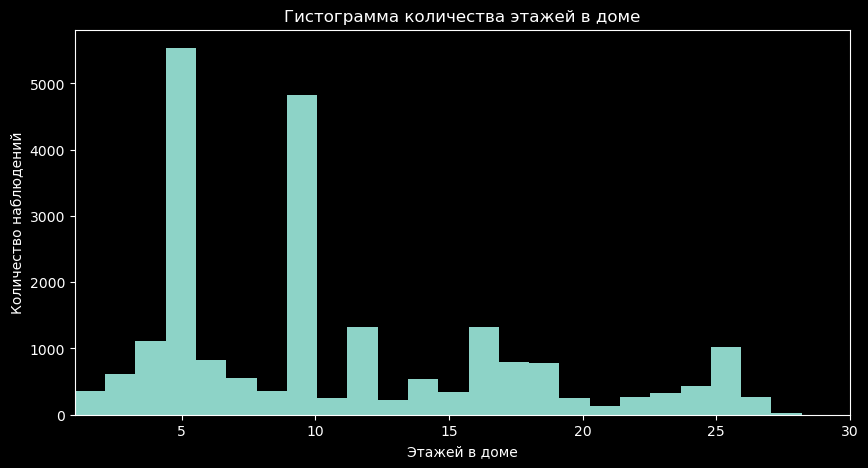

In [266]:
data['floors_total'].plot(kind='hist', bins=30, xlim=(1, 30))
plt.title('Гистограмма количества этажей в доме')
plt.ylabel('Количество наблюдений')
plt.xlabel('Этажей в доме');


In [267]:
# Большая часть наблюдений до 30 этажей. Чаще всего встречаются 5-ти этажки хрущевки.
# Вот топ-5 с самым болшим количеством этажей
# 5     5538
# 9     3688
# 12    1327
# 16    1324
# 10    1144

#### Расстояние до центра города в метрах

In [268]:
data['cityCenters_nearest']

0        16028.0
1        18603.0
2        13933.0
3         6800.0
4         8098.0
          ...   
23694     4232.0
23695        NaN
23696        NaN
23697    10364.0
23698        NaN
Name: cityCenters_nearest, Length: 22538, dtype: float64

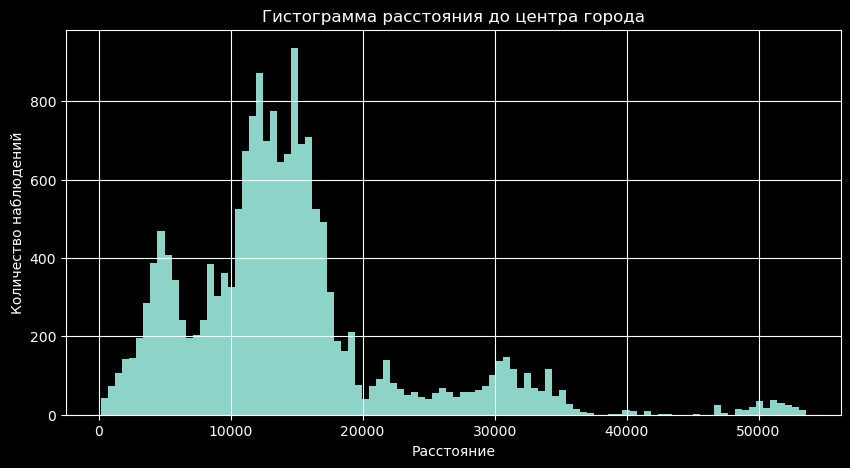

In [269]:
data['cityCenters_nearest'].hist(bins=100)
plt.title('Гистограмма расстояния до центра города')
plt.ylabel('Количество наблюдений')
plt.xlabel('Расстояние');

# бОльшая часть данных лежит до 35км от центра

In [270]:
data['cityCenters_nearest'].value_counts()

8460.0     61
10720.0    30
20802.0    28
8434.0     27
10364.0    26
           ..
12574.0     1
6377.0      1
4144.0      1
31729.0     1
6263.0      1
Name: cityCenters_nearest, Length: 7405, dtype: int64

In [271]:
# разобьем данные на интервалы, используя квантили, разделили на равные части

pd.qcut(data['cityCenters_nearest'], 3).value_counts()

(180.999, 11178.333]      5773
(11178.333, 15205.333]    5773
(15205.333, 53568.0]      5773
Name: cityCenters_nearest, dtype: int64

In [272]:
data['cityCenters_nearest'].describe()

count    17319.000000
mean     14309.815232
std       8506.407321
min        181.000000
25%       9496.000000
50%      13174.000000
75%      16371.000000
max      53568.000000
Name: cityCenters_nearest, dtype: float64

**ВЫВОД:** Гистограмма имеет 3 выраженных пика. 
* (180.999, 11177.0]    5775
* (11177.0, 15205.0]    5775
* (15205.0, 53568.0]    5773

Самый удаленный объект на расстоянии 54км, самый близкий менее 182м

Чаще всего встречаются объекты в 13-15км

#### Расстояние до ближайшего аэропорта

In [273]:
data['airports_nearest']

0        18863.0
1        12817.0
2        21741.0
3        28098.0
4        31856.0
          ...   
23694    24665.0
23695        NaN
23696        NaN
23697    39140.0
23698        NaN
Name: airports_nearest, Length: 22538, dtype: float64

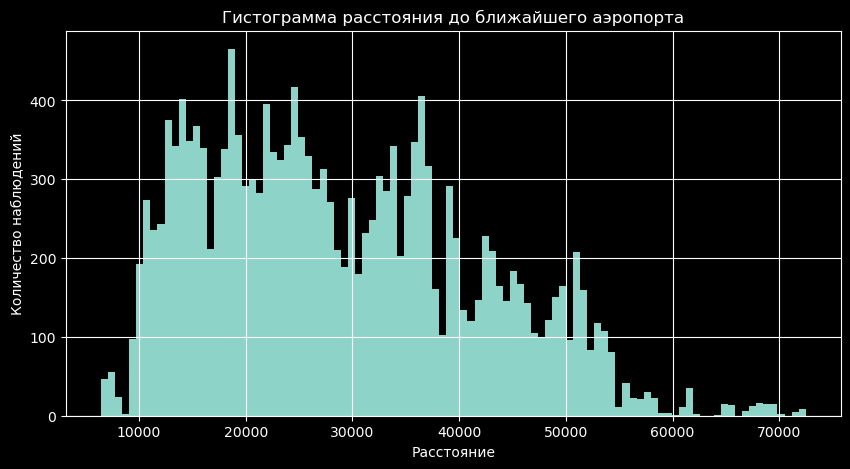

In [274]:
data['airports_nearest'].hist(bins=100)
plt.title('Гистограмма расстояния до ближайшего аэропорта')
plt.ylabel('Количество наблюдений')
plt.xlabel('Расстояние');


# на гистограмме вижу хвост справа


In [275]:
# разобьем данные на интервалы, используя квантили, разделили на равные части

pd.qcut(data['airports_nearest'], 5).value_counts()

(16705.6, 23604.0]     3465
(31685.8, 40088.0]     3461
(6449.999, 16705.6]    3460
(40088.0, 72469.0]     3459
(23604.0, 31685.8]     3454
Name: airports_nearest, dtype: int64

In [276]:
data['airports_nearest'].describe()

count    17299.000000
mean     28845.956471
std      12634.967734
min       6450.000000
25%      18499.000000
50%      26884.000000
75%      37407.000000
max      72469.000000
Name: airports_nearest, dtype: float64

**ВЫВОД:** Гистограмма имеет выраженный пик. 
Топ распредлений:
* (16703.2, 23604.0]     3466
* (6449.999, 16703.2]    3461
* (31687.8, 40088.0]     3461
* (40088.0, 72469.0]     3460
* (23604.0, 31687.8]     3455


Чаще всего встречаются объекты в примерно в 10-30 км от ажропорта

#### Расстояние до ближайшего парка

In [277]:
data['parks_nearest']

0        482.0
1          NaN
2         90.0
3         84.0
4        112.0
         ...  
23694    796.0
23695      NaN
23696      NaN
23697    173.0
23698      NaN
Name: parks_nearest, Length: 22538, dtype: float64

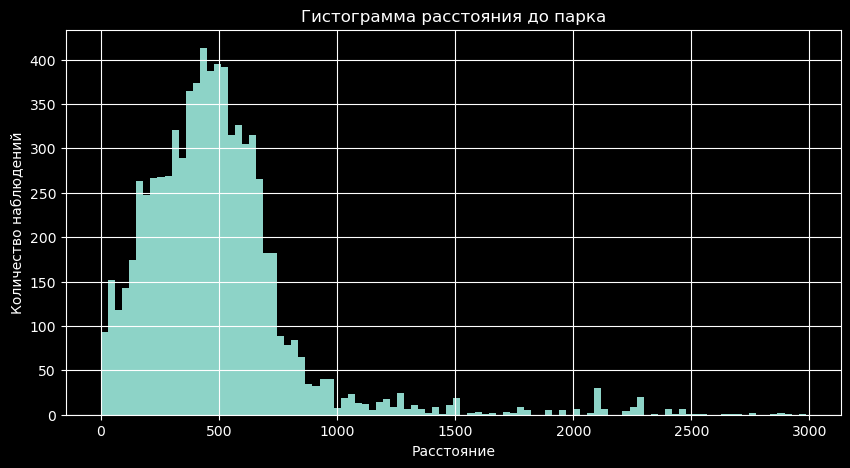

In [278]:
data['parks_nearest'].hist(bins=100)
plt.title('Гистограмма расстояния до парка')
plt.ylabel('Количество наблюдений')
plt.xlabel('Расстояние');


# на гистограмме вижу длинный хвост справа
# также вижу пик в райне 500м

In [279]:
data['parks_nearest'].value_counts(dropna=False)

NaN       14899
441.0        67
173.0        39
392.0        39
456.0        39
          ...  
467.0         1
873.0         1
859.0         1
1150.0        1
2984.0        1
Name: parks_nearest, Length: 982, dtype: int64

In [280]:
# разобьем данные на интервалы, используя квантили, разделили на равные части

pd.qcut(data['parks_nearest'], 3).value_counts()

(0.999, 353.0]     2555
(551.0, 2984.0]    2544
(353.0, 551.0]     2540
Name: parks_nearest, dtype: int64

In [281]:
data['parks_nearest'].describe()

count    7639.000000
mean      490.198979
std       335.598964
min         1.000000
25%       288.000000
50%       456.000000
75%       612.000000
max      2984.000000
Name: parks_nearest, dtype: float64

**ВЫВОД:** Гистограмма имеет выраженный пик в районе 500 м.

Самый удаленный объект на расстоянии  3 км, самый близкий менее 1м, 
возможно, здание находится на территории парка!


#### День и месяц публикации объявления

In [282]:
# Проанализируем день и месяц публикации.

In [283]:
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 22538, dtype: datetime64[ns]

##### День

In [284]:
# 0 — понедельник, 1 — вторник, 2 - среда, 3- четверг и т.д

In [285]:
data['day_of_week_publication'].value_counts()
# чаще всего выкладывают объявления в четверг, реже всего в в воскресенье

3    4052
1    3965
4    3829
2    3785
0    3444
5    1842
6    1621
Name: day_of_week_publication, dtype: int64

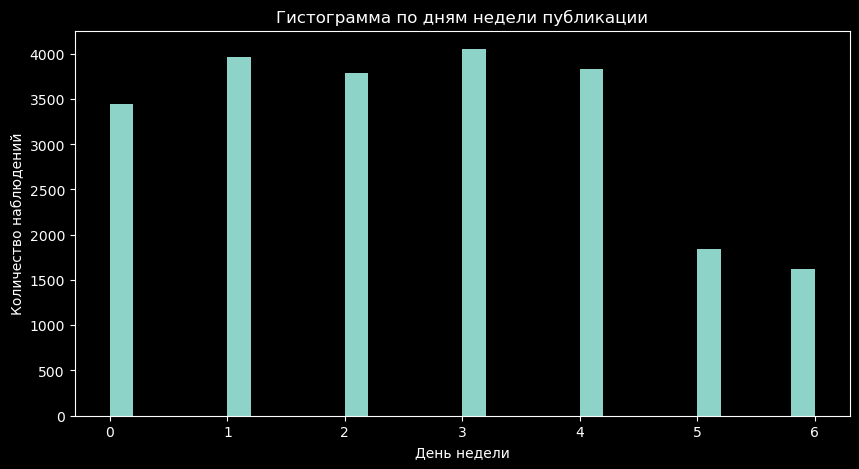

In [286]:
data['day_of_week_publication'].plot(kind='hist', bins=30)
plt.title('Гистограмма по дням недели публикации')
plt.ylabel('Количество наблюдений')
plt.xlabel('День недели');


##### Месяц

In [287]:
data['month_of_publication'].value_counts()
# чаще всего выкладывают объявления в феврале, реже всего в мае

2     2508
3     2454
4     2277
11    2261
10    2032
9     1888
6     1679
8     1662
7     1596
12    1546
1     1424
5     1211
Name: month_of_publication, dtype: int64

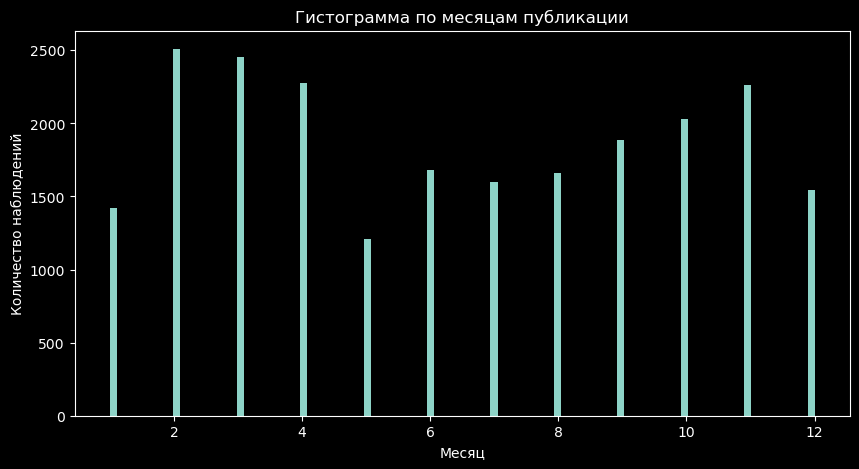

In [288]:
# видим тренд на повышение количества объявлений в марте
data['month_of_publication'].plot(kind='hist', bins=100)
plt.title('Гистограмма по месяцам публикации')
plt.ylabel('Количество наблюдений')
plt.xlabel('Месяц');

#### Скорость продажи квартиры

In [289]:
data['days_exposition']

0          NaN
1         81.0
2        558.0
3        424.0
4        121.0
         ...  
23694      NaN
23695     45.0
23696      NaN
23697    602.0
23698      NaN
Name: days_exposition, Length: 22538, dtype: float64

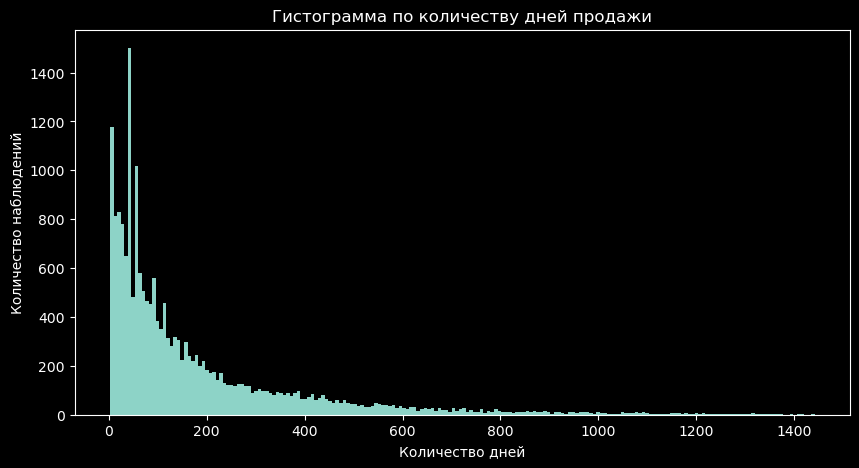

In [290]:
data['days_exposition'].plot(kind='hist', bins=200)
plt.title('Гистограмма по количеству дней продажи')
plt.ylabel('Количество наблюдений')
plt.xlabel('Количество дней');

In [291]:
# топ 5 по количеству дней продаж
data['days_exposition'].value_counts().head()

# здесь мы видим, что чаще всего объявление висит 45 дней

45.0    840
60.0    521
7.0     212
30.0    199
90.0    188
Name: days_exposition, dtype: int64

In [292]:
data['days_exposition'].describe()

# в среднем объявление висит 180 дней. Медиана говорит около 95 дней

count    19519.000000
mean       179.937036
std        216.651358
min          3.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1441.000000
Name: days_exposition, dtype: float64

In [293]:
data.groupby('locality_name')['days_exposition']\
                        .mean().to_frame()\
                        .sort_values(by='days_exposition', ascending=False)\
                        .head(10)

,days_exposition
locality_name,
севастьяново,1069.000000
рабитицы,1007.000000
коробицыно,750.000000
большая пустомержа,627.000000
высоцк,570.333333
мины,540.000000
лисий нос,518.000000
рябово,498.750000
ваганово,462.333333


<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Сгруппировав по населенным пунктам теперь вижу, что "за второй столицей" время продажи возрастает!

In [294]:
data.groupby('year_of_publication')['days_exposition']\
                        .agg(['count', 'mean'])\
                        .sort_values(by='mean', ascending=False)\
                        .head(10)

,count,mean
year_of_publication,,
2014,104,877.336538
2015,1058,641.677694
2016,2589,321.572036
2017,7570,158.690621
2018,7187,94.196605
2019,1011,30.884273


In [295]:
data['last_price'].describe()

count    2.253800e+04
mean     6.007047e+06
std      5.464433e+06
min      5.000000e+05
25%      3.450000e+06
50%      4.630000e+06
75%      6.700000e+06
max      1.243500e+08
Name: last_price, dtype: float64

In [296]:
# видим, что быстрее всего покупают квартиры в санкт петербурге стоимость менее 10 млн рублей, относящееся
# к среднему ценовому сегменту

<Axes: ylabel='Frequency'>

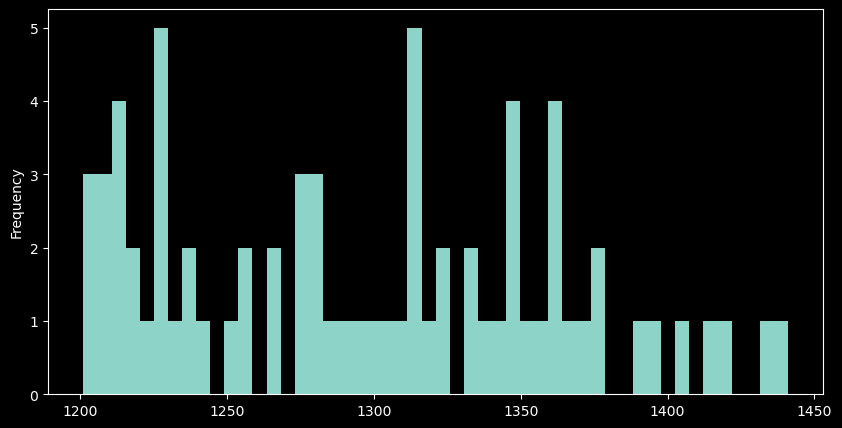

In [297]:
# построю гистограмму 
data.query('days_exposition > 1200')['days_exposition'].plot(kind='hist', bins=50)

In [298]:
# сгруппирую по населенным пунктам 
data.query('days_exposition > 1200').groupby('locality_name')['days_exposition'].agg(['count'])

# видим, что бОльшая часть продаж приходится на Санкт-Петербург

,count
locality_name,
всеволожск,1
вырица,1
коммунар,3
красное,1
кронштадт,1
кудрово,1
лисий нос,1
лодейное поле,1
нурма,1


In [299]:
data.query('days_exposition > 1200 ').groupby('type_price')['days_exposition'].agg(['count'])

,count
type_price,
дешевая,15
дорогая,2
средняя,55


In [300]:
# видим, что дольше всего продаются квартиры в Санкт-Петербурге со средним ценовым сегментом

In [301]:
data.query('days_exposition > 1200')['last_price'].describe()

count    7.200000e+01
mean     9.565563e+06
std      7.081495e+06
min      1.150000e+06
25%      4.425000e+06
50%      8.050000e+06
75%      1.197625e+07
max      3.595350e+07
Name: last_price, dtype: float64

**ВЫВОД:** Быстрее всего продаются квартиры в санкт петербурге со средним и дешевым ценовыми диапазонами с близким расстоянием до центра и до аэропорта. Дольше всего продаются квартиры в санкт петербурге со средним и дешевым ценовыми диапазонами, которые далеко находятся до центра и до аэропорта. Интересно отметить, что дорогое и элитное жилье продается гораздо быстрее.

### Факторы, влияющие на стоимость объекта

* общей площади; - зависит
* жилой площади; - зависит
* площади кухни; - зависит
* количества комнат; - зависит
* этажа, на котором расположена квартира (первый, последний, другой); - зависит
* даты размещения (день недели, месяц, год). - зависит

In [302]:
# Рассмотрим факторы, влияющие на цену, используя коэффициент корреляции phik
# Видим выше, что коэффицент корреляции phik, показывает, что все
# эти перменные зависят от целевой перменной. Phik также находит нелинейные связи.
phik['last_price'].sort_values(ascending=False).loc[lambda x: x> 0.05]

last_price              1.000000
first_day_exposition    0.629131
total_area              0.552086
living_area             0.490001
kitchen_area            0.381084
rooms                   0.302975
cityCenters_nearest     0.244909
ponds_around3000        0.165390
parks_around3000        0.160286
airports_nearest        0.130572
total_images            0.101848
ponds_nearest           0.084575
balcony                 0.082124
days_exposition         0.080222
parks_nearest           0.065703
floors_total            0.058385
Name: last_price, dtype: float64

<Axes: >

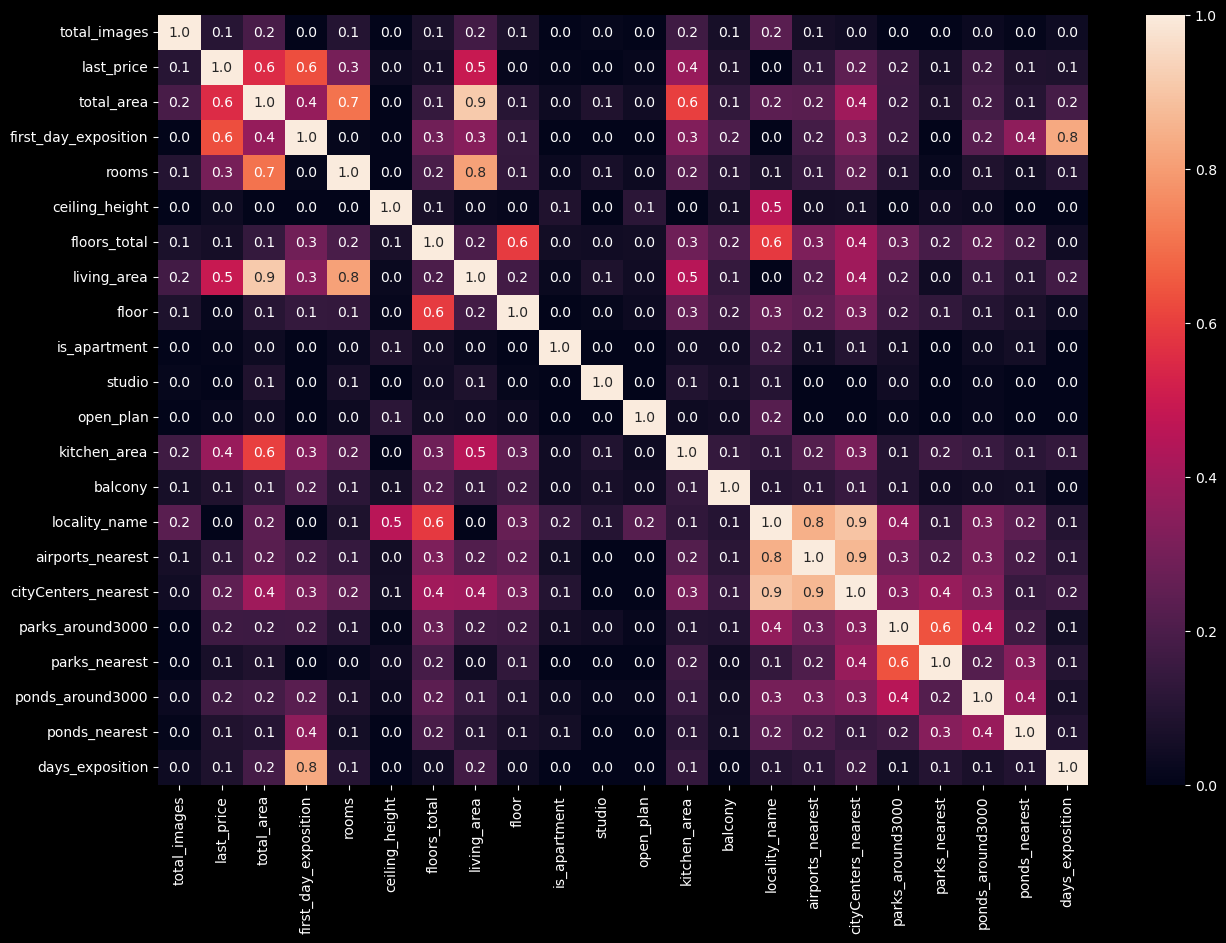

In [303]:
# Зависимость от всех этих переменных есть, визуализирую heatmap
plt.rcParams['figure.figsize']=(15,10) # изменение размера

sns.heatmap(phik, fmt=".1f", annot=True)


* общей площади; - зависит
* жилой площади; - зависит
* площади кухни; - зависит
* количества комнат; - зависит
* этажа, на котором расположена квартира (первый, последний, другой); - зависит
* даты размещения (день недели, месяц, год). - зависит

In [304]:
# теперь построим диаграммы рассеяния, чтобы посмотреть как ведут себя значения на корелированных переменных
# запишем переменные для рассмотрения
X = ['last_price', 'total_area', 'living_area', 'kitchen_area',
    'rooms', 'type_floors', 'day_of_week_publication',
    'month_of_publication', 'year_of_publication']

**Для рассмотрения возьмем самые распространненные значения:**
* total_area < 201
* living_area < 130 млн
* kitchen_area < 140
* rooms 1-7
* type_floors
* day_of_week_publication
* month_of_publication
* year_of_publication

In [305]:
data_plot = data.query('last_price < 9000000')
data_plot
# для удобства визуализации рссмотрим значения цен меньше 80 млн

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square meter,day_of_week_publication,month_of_publication,year_of_publication,type_floors,cityCenters_nearest_to_km,type_price
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,False,False,11.0,2.0,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0,дешевая
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,False,False,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0,средняя
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0.0,янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN,дешевая
6,6,3700000.0,37.3,2017-11-02,1,2.66,26,10.6,6,False,False,False,14.4,1.0,парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0,дешевая
7,5,7915000.0,71.6,2019-04-18,2,2.75,24,44.3,22,False,False,False,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,другой,12.0,средняя
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.0,2017-07-07,1,2.55,5,17.5,4,False,False,False,6.0,0.0,тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0,45000.000000,4,7,2017,другой,NaN,дешевая
23693,9,4600000.0,62.4,2016-08-05,3,2.60,9,40.0,8,False,False,False,8.0,0.0,петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0,73717.948718,4,8,2016,другой,34.0,средняя
23695,14,3100000.0,59.0,2018-01-15,3,2.55,5,38.0,4,False,False,False,8.5,0.0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542.372881,0,1,2018,другой,NaN,дешевая
23696,18,2500000.0,56.7,2018-02-11,2,2.80,3,29.7,1,False,False,False,8.4,0.0,рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091.710758,6,2,2018,первый,NaN,дешевая


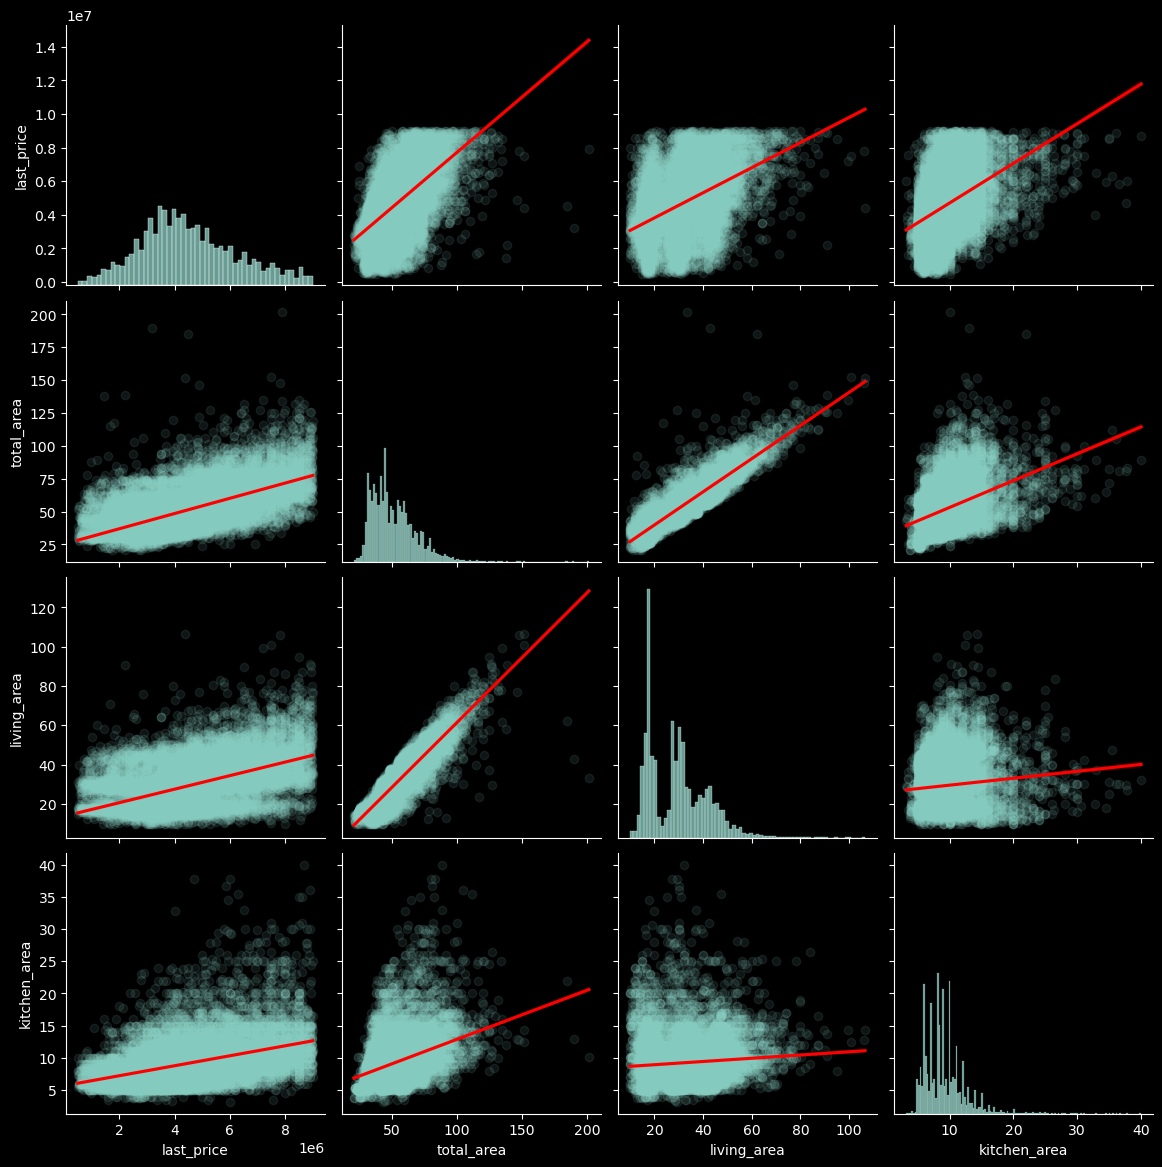

In [306]:
# Рассмотрим зависимость цены 
sns.pairplot(data_plot[['last_price', 'total_area', 'living_area', 'kitchen_area']],
                             kind='reg',
                             plot_kws={'line_kws':{'color':'red'},
                                       'scatter_kws': {'alpha': 0.1}})
plt.gcf().set_size_inches(12,12);


<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Модицифировав график, добавив линейную регрессию, можем наблюдать следующие зпасимости: 
        
        
* Видим сильные линейные связи
* С ростом жилой площади идет рост цены
* С ростом кухни площади идет рост цены
* С ростом общей площади идет рост цены
* Также площади имеют линейную зависимость друг с другом

C:\ProgramData\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


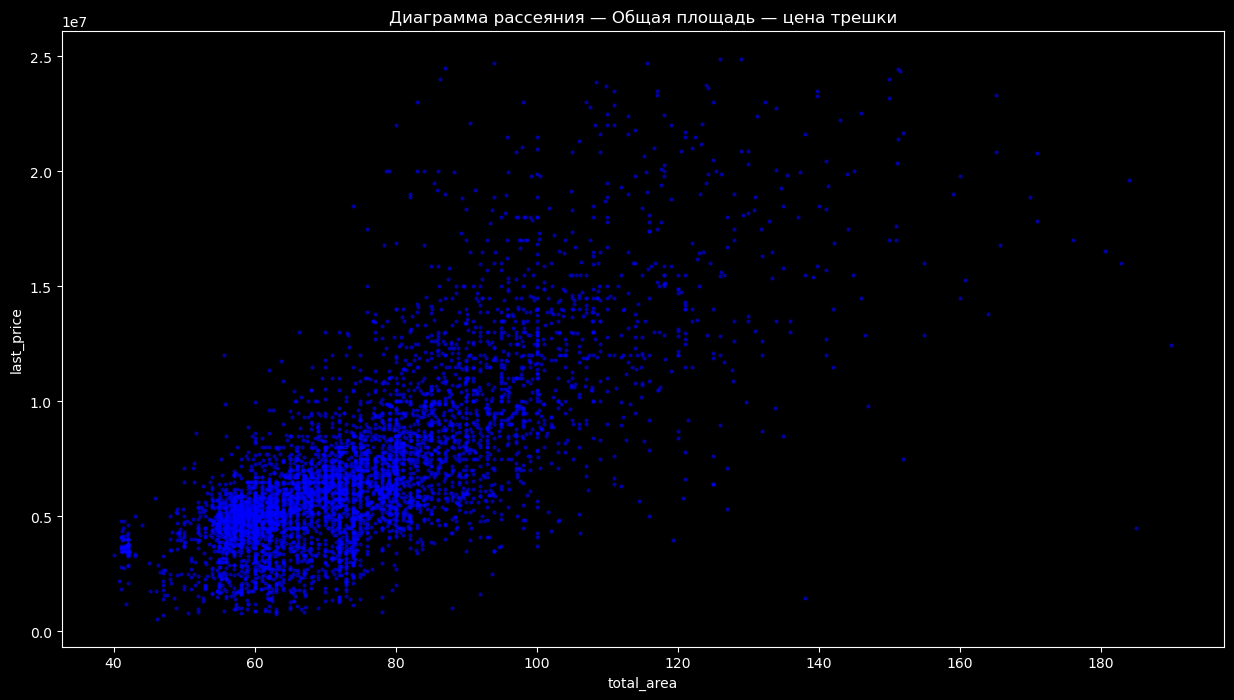

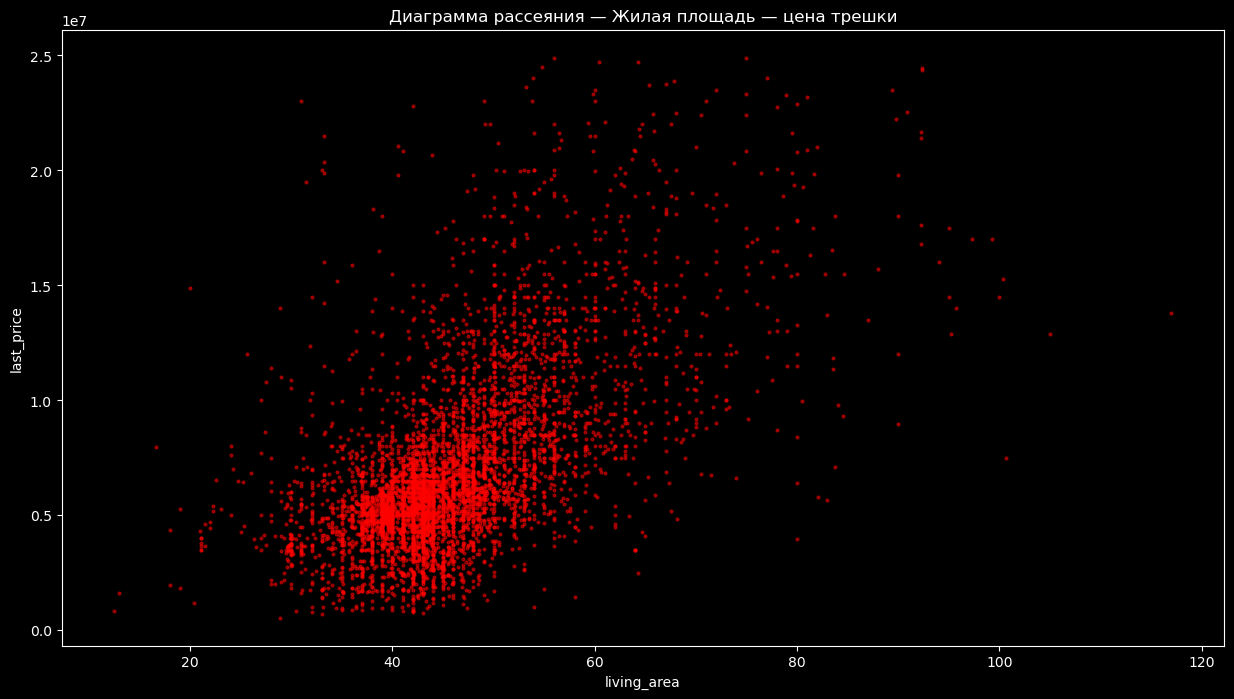

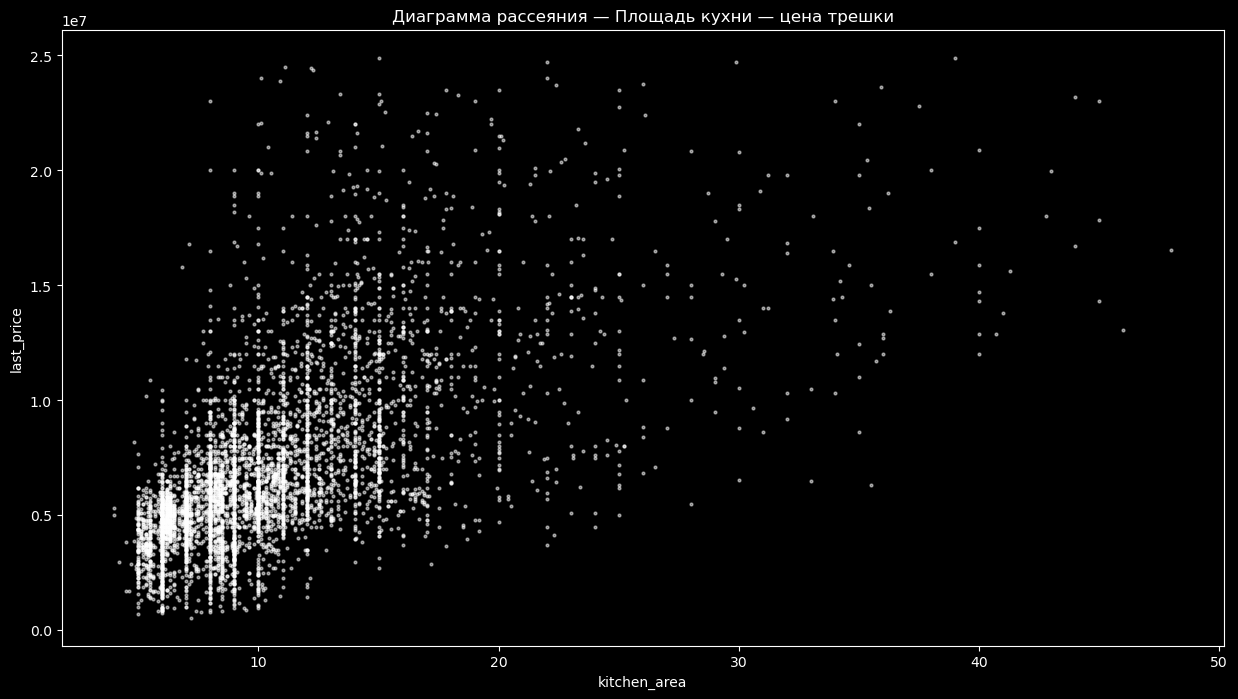

In [307]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='kitchen_area', alpha=0.5, figsize=(15,8), c = 'w', s = 4)
plt.title('Диаграмма рассеяния — Площадь кухни — цена трешки');

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Рассмотрев графики ближе закономерности выше подтверждаются. Ниже буду рассматривать остальные переменные

**Рассмотрим оставшиеся переменные, строя сводные таблицы:**

* 'rooms', 
* 'type_floors', 
* 'day_of_week_publication',
* 'month_of_publication', 
* 'year_of_publication'

#### Смотрим зависимость количества комнат от цены

In [308]:
data.groupby('rooms')['last_price'].agg(['count', 'mean'])

,count,mean
rooms,,
1,7745,3.837253e+06
2,7726,5.507857e+06
3,5616,7.845903e+06
4,1105,1.202579e+07
5,262,1.580433e+07
6,61,1.977271e+07
7,23,1.807087e+07


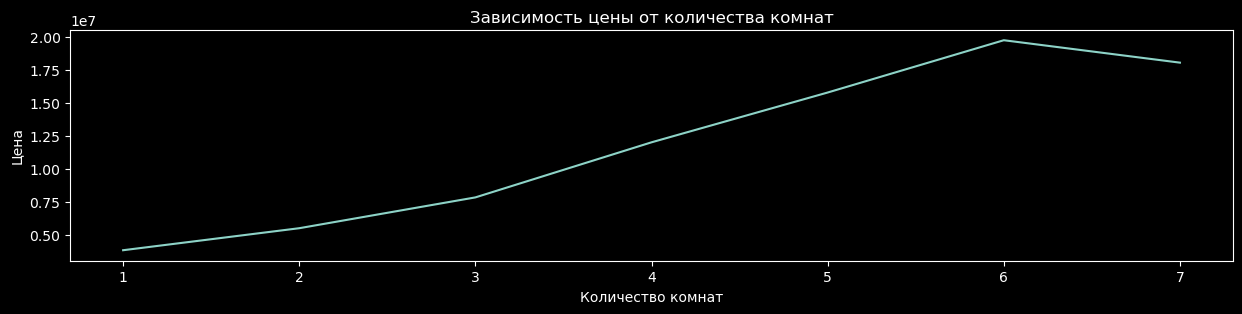

In [309]:
data.groupby('rooms')['last_price'].agg(['count', 'mean'])['mean'].plot(figsize=(15, 3))
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены от количества комнат');

**Вывод:** c ростом цены наблюдается линейная зависимость с увеличением количества комнат.

#### type_floors

In [310]:
data.groupby('type_floors')['last_price'].agg(['count', 'mean'])

,count,mean
type_floors,,
другой,16658,6.289896e+06
первый,2755,4.612669e+06
последний,3125,5.728586e+06


**Вывод:** видим зависимость, что на первом этаже квартиры имеют меньшую цену. Чуть дороже по сравнению с первым этажом стоят квартиры на последних этажах. Дороже всего стоят квартиры между 1 и последним этажами.

#### day_of_week_publication

In [311]:
data.groupby('day_of_week_publication')['last_price'].agg(['count', 'mean'])

,count,mean
day_of_week_publication,,
0,3444,6.018790e+06
1,3965,5.964645e+06
2,3785,5.993463e+06
3,4052,6.242323e+06
4,3829,5.906123e+06
5,1842,5.940923e+06
6,1621,5.842950e+06


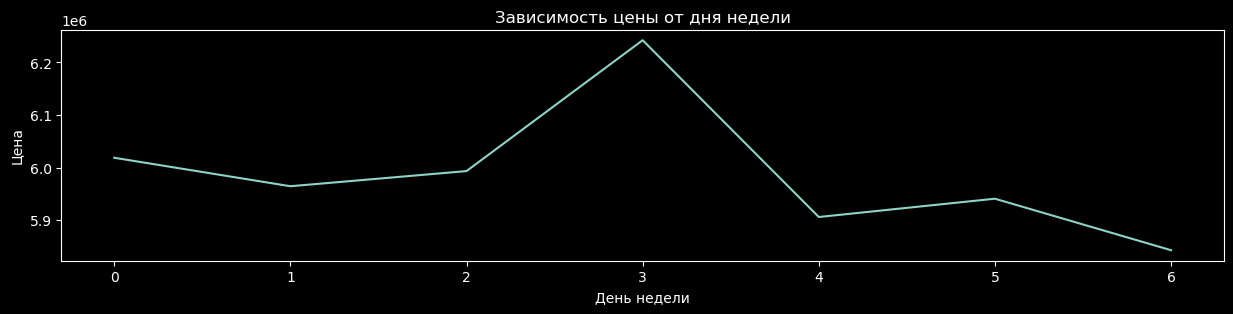

In [312]:
data.groupby('day_of_week_publication')['last_price'].agg(['count', 'mean'])['mean'].plot(figsize=(15, 3))
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.title('Зависимость цены от дня недели');

**Вывод:** наибольшая цена имеют объявления, выложенные в четверг, видим скачок в середине недели. А наименьшая цена в воскресенье.

#### month_of_publication

In [313]:
data.groupby('month_of_publication')['last_price']\
                            .agg(['count', 'mean'])\
                            .sort_values(by='mean', ascending=False)

,count,mean
month_of_publication,,
12,1546,6.327392e+06
8,1662,6.157624e+06
9,1888,6.127929e+06
2,2508,6.080171e+06
5,1211,6.077135e+06
7,1596,6.016702e+06
11,2261,6.009609e+06
1,1424,5.984544e+06
4,2277,5.905572e+06


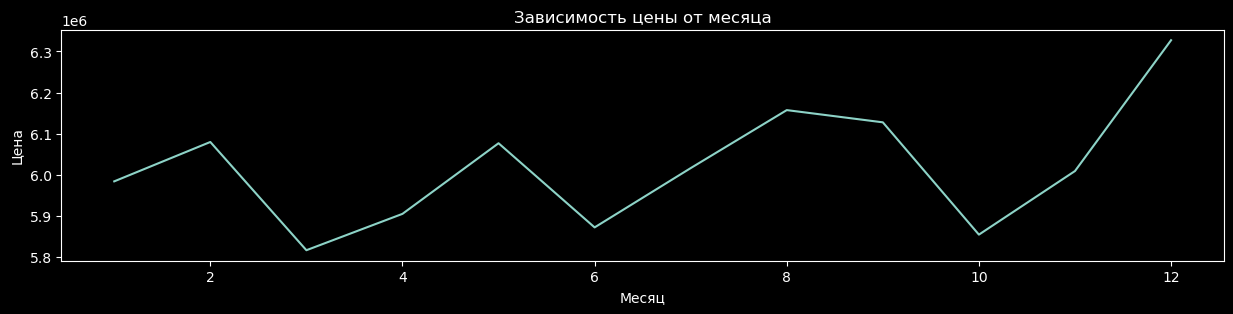

In [314]:
data.groupby('month_of_publication')['last_price'].agg(['count', 'mean'])['mean'].plot(figsize=(15, 3))
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.title('Зависимость цены от месяца');

**Вывод:** на графике я вижу тенденцию к переодичности роста и спада цены. Наибольшая цена в декабре, а наименьшая цена в марте.

#### year_of_publication

In [315]:
data.groupby('year_of_publication')['last_price'].agg(['count', 'mean'])

,count,mean
year_of_publication,,
2014,122,1.164767e+07
2015,1122,7.298905e+06
2016,2652,6.190770e+06
2017,7819,5.908557e+06
2018,8087,5.666569e+06
2019,2736,6.335514e+06


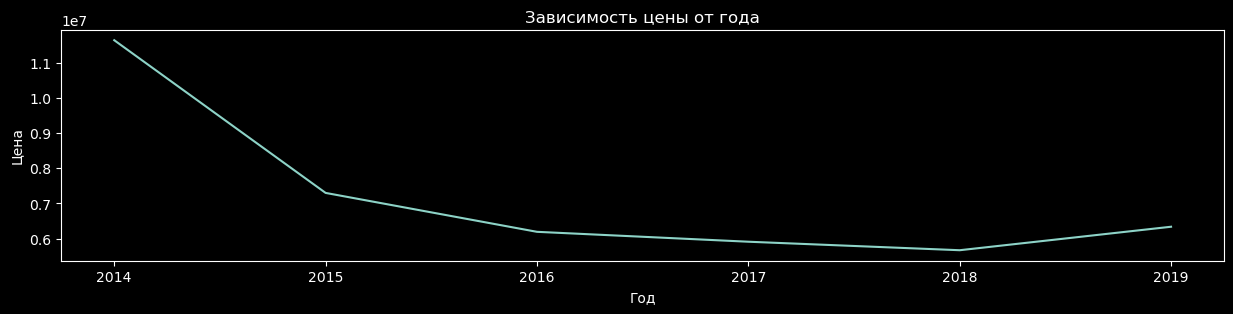

In [316]:
data.groupby('year_of_publication')['last_price'].agg(['count', 'mean'])['mean'].plot(figsize=(15, 3))
plt.xlabel('Год')
plt.ylabel('Цена')
plt.title('Зависимость цены от года');

**Вывод:** наблюдается зависимость с падением цены от роста года, с 14 года цена была максимальна, затем началось ее падение. После 18 года есть тенденция к росту цены на недвижимость.

**ВЫВОД:** По коэффициенту корреляции phik, выявляющий и нелинйеные связи мы получили, что last_price зависит от переменных
'total_area', 'living_area', 'kitchen_area','rooms', 'type_floors', 'day_of_week_publication','month_of_publication', 'year_of_publication'.

На heatmap это отражено нагляднее. Затем я построил диаграммы рассеивания и там видно, 
* Видим сильные линейные связи
* С ростом жилой площади идет рост цены
* С ростом кухни площади идет рост цены
* С ростом общей площади идет рост цены
* Также площади имеют линейную зависимость друг с другом
* c ростом цены наблюдается линейная зависимость с увеличением количества комнат.
* наибольшая цена имеют объявления, выложенные в четверг, видим скачок в середине недели. А наименьшая цена в воскресенье.
*  на графике я вижу тенденцию к переодичности роста и спада цены. Наибольшая цена в декабре, а наименьшая цена в марте.
* наблюдается зависимость с падением цены от роста года, с 14 года цена была максимальна, затем началось ее падение. После 18 года есть тенденция к росту цены на недвижимость.


Также заметим, что день, месяц, год публикации тоже влияют на цену. 

## Подсчет цены

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [317]:
# 10 населённых пунктах с наибольшим числом объявлений
t = data.groupby('locality_name')['last_price']\
                    .agg(['count'])\
                    .sort_values(by='count', ascending=False).head(10)
t

,count
locality_name,
санкт-петербург,14928
мурино,517
кудрово,435
шушары,432
всеволожск,379
пушкин,355
колпино,330
парголово,320
гатчина,300


<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Нашел 10 самых больших наблюдений по количеству объявлений

In [318]:
t = data.groupby('locality_name')['price_one_square meter']\
                    .agg(['count', 'mean'])\
                    .sort_values(by='count', ascending=False).head(10)
t

,count,mean
locality_name,,
санкт-петербург,14928,112499.637378
мурино,517,85057.056240
кудрово,435,94757.044751
шушары,432,78447.041022
всеволожск,379,68581.203169
пушкин,355,102605.115860
колпино,330,75286.766372
парголово,320,89866.646648
гатчина,300,68694.019852


In [319]:
t.sort_values(by='mean', ascending=False)

,count,mean
locality_name,,
санкт-петербург,14928,112499.637378
пушкин,355,102605.115860
кудрово,435,94757.044751
парголово,320,89866.646648
мурино,517,85057.056240
шушары,432,78447.041022
колпино,330,75286.766372
гатчина,300,68694.019852
всеволожск,379,68581.203169


**ВЫВОД:** Самая высокая стоимость квадратного метра 112499.637378 в Санкт-Петербурге. Самая низкая стоимость квадратного метра 58449.611324 в Выборге. На втором месте по стоимости квадратного метра для топ-10 наблюдений расположился Пушкин со стоимостью 102605.115860.

## Средняя цена километра

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [320]:
test_data = data.copy(deep=True)

In [321]:
test_data = test_data.query('locality_name == "санкт-петербург"')

In [322]:
t = test_data.groupby('cityCenters_nearest_to_km')['last_price']\
                                        .agg(['count', 'mean'])\
                                        .reset_index()
t

,cityCenters_nearest_to_km,count,mean
0,0.0,20,1.964515e+07
1,1.0,158,1.290405e+07
2,2.0,269,1.474632e+07
3,3.0,319,1.035208e+07
4,4.0,636,1.095944e+07
5,5.0,827,1.162555e+07
6,6.0,556,1.202367e+07
7,7.0,394,1.332396e+07
8,8.0,572,8.885239e+06
9,9.0,562,6.861817e+06


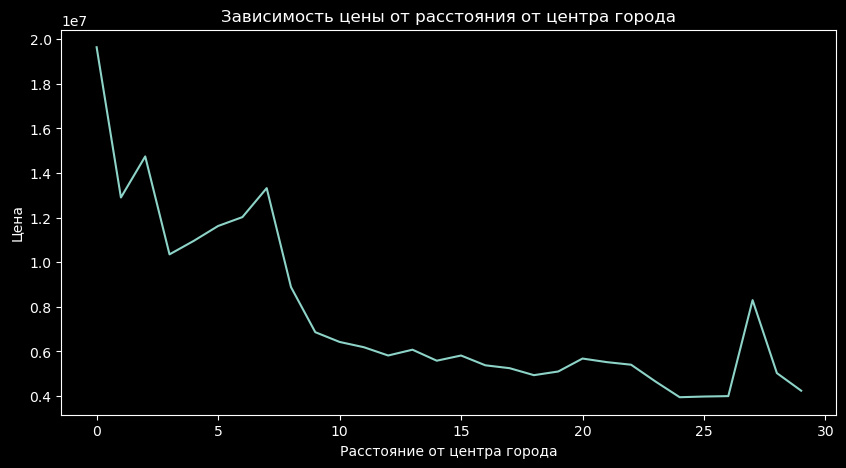

In [323]:
# здесь видим, что с ростом километража цена начинает падать
plt.rcParams['figure.figsize']=(10,5)
plt.plot(t['cityCenters_nearest_to_km'], t['mean'])
plt.xlabel('Расстояние от центра города')
plt.ylabel('Цена')
plt.title('Зависимость цены от расстояния от центра города');

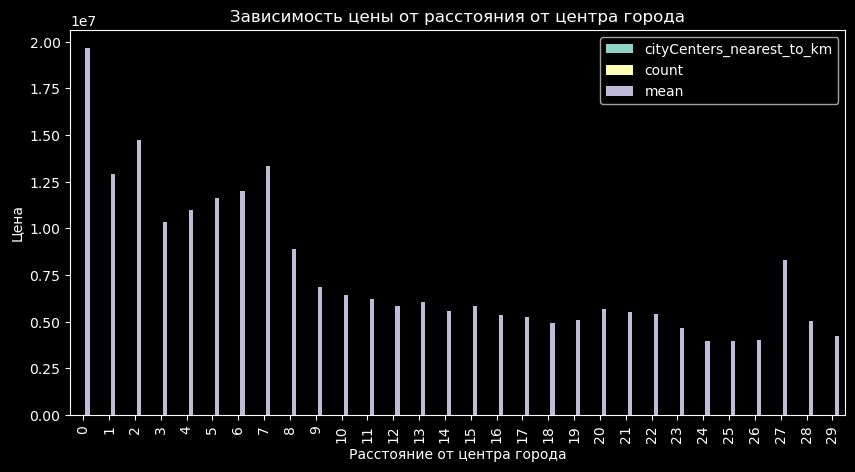

In [324]:
# Здесь эта тенденция выражена нагляднее
t.plot(kind='bar');
plt.xlabel('Расстояние от центра города')
plt.ylabel('Цена')
plt.title('Зависимость цены от расстояния от центра города');

<div class="alert alert-info">
<font size="4", color = "black"><b></b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Рассмотрим скачки на 2, 7  и 27 км.

In [325]:
# изучим подробнее резкий скачок в районе 27км от центра

test_data.query('cityCenters_nearest_to_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square meter,day_of_week_publication,month_of_publication,year_of_publication,type_floors,cityCenters_nearest_to_km,type_price
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,False,False,25.0,0.0,санкт-петербург,23888.0,27313.0,1.0,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0,средняя
5961,6,2250000.0,32.0,2018-02-27,1,2.70,2,16.5,2,False,False,False,7.0,0.0,санкт-петербург,24006.0,27431.0,0.0,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,последний,27.0,дешевая


In [326]:
# способы группировки и сортировки информации

(
    data
     .query('locality_name == "санкт-петербург"')
     .query('3 <= cityCenters_nearest_to_km <=5 ')
     .groupby(['cityCenters_nearest_to_km', 'type_floors'])['last_price']
     .agg(['count', 'mean', 'median'])
     .style.format("{:,.0f}")
)

**ВЫВОД:** Стоимость объектов зависит от расстояния от центра, на графиках выше мы наблюдаем тенденцию к падению цену с ростом километража от центра, кроме 27 км, там есть небольшие скачки цены.

### Общий вывод

**Передо мной стояла следующая задача:**
Выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.. **Запишу выводы:**

* В данных было **очень много пропусков**, особенно в картографических переменных parks_nearest и ponds_nearest. Картографические пропуски было решено оставить, чтобы отправить их эксперту на проверку, иначе бы это сильно исказило результаты.




* **Большинство пропусков удалось заполнить** исходя из простых группировок и проверок адекватности данных, к примеру, что общая площадь не может быть меньше суммы площади кухни и жилой площади. Устраивая такие проверки при заполнении пропусков получается сохранять адекватность данных. 




* **В данных было много аномалий, которые успешно распознали и удалили.**


* **Изначально некоторые типы данных были опредлены неверно**, например, дату определили строкой. Также некоторые переменных изменили на object, чтобы работать с ними как с категориальными фичами, а также для удобства группировки.




* Изучили переменные и выяснили о том, что **большинство переменных содержат длинные хвосты в распределениях**. Рассмотрели к переменным основные статистики. Избавились от выбросов, что помогло сократить длинные хвосты.




* По коэффициенту корреляции phik, выявляющий и нелинйеные связи мы получили, что **last_price зависит от переменных**'total_area', 'living_area', 'kitchen_area','rooms', 'type_floors', 'day_of_week_publication','month_of_publication', 'year_of_publication'.

* На heatmap это отражено нагляднее. Затем я построил диаграммы рассеивания и там видно, 
* Видим сильные линейные связи
* С ростом жилой площади идет рост цены
* С ростом кухни площади идет рост цены
* С ростом общей площади идет рост цены
* Также площади имеют линейную зависимость друг с другом
* c ростом цены наблюдается линейная зависимость с увеличением количества комнат.
* наибольшая цена имеют объявления, выложенные в четверг, видим скачок в середине недели. А наименьшая цена в воскресенье.
*  на графике я вижу тенденцию к переодичности роста и спада цены. Наибольшая цена в декабре, а наименьшая цена в марте.
* наблюдается зависимость с падением цены от роста года, с 14 года цена была максимальна, затем началось ее падение. После 18 года есть тенденция к росту цены на недвижимость.


* **Также заметим, что день, месяц, год публикации тоже влияют на цену.**



* **Самая высокая стоимость квадратного метра в среднем по топ-10 наблюдений** 112499.637378 в Санкт-Петербурге. Самая низкая стоимость квадратного метра 58449.611324 в Выборге. На втором месте по стоимости квадратного метра для топ-10 наблюдений расположился Пушкин со стоимостью 102605.115860.



* **Стоимость объектов зависит от расстояния от центра**, на графиках выше мы наблюдаем тенденцию к падению цену с ростом километража от центра, кроме 27 км, там есть небольшие скачки цены.